In [62]:
import json
import matplotlib.pyplot as plt
import operator
import os
import sys
import typing
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

In [4]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI",
                                       tuning_param: float = 0.5):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
    )
    return run_modules(default_user_inp_raw)

In [5]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None, tuning_param: int = 0.5):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path,
                                                   tuning_param=tuning_param)

In [6]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [7]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies

    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    df_dict = {"codon": list(codons_counter.keys()), "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons_counter.keys()], "frequency": list(codons_counter.values())}
    return pd.DataFrame(df_dict)

In [8]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [9]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [10]:
def get_variants_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")

        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
        series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)

        ecoli_dist = calculate_distance_between_frequencies(series1, series2)
        bacillus_dist = calculate_distance_between_frequencies(series1, series3)

        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
        else:
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
        df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
        df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])

        df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
        df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
        df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
    
    return df_dict

In [11]:
def get_cub_score_df_dict(root_dir) -> None:
    filename = "run_summary.json"
    
    unified_variants_dict = defaultdict(dict)
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)
                
                is_cai = directory_name.startswith("CAI")
                organisms = results_json["evaluation"]["organisms"]
                for organism in organisms:
                    if organism["name"] == "Bacillus subtilis":
                        if is_cai:
                            bacillus_initial_score = organism["cai_initial_score"]
                            bacillus_final_score = organism["cai_final_score"]
                        else:
                            bacillus_initial_score = organism["tai_initial_score"]
                            bacillus_final_score = organism["tai_final_score"]
                    else:
                        if is_cai:
                            ecoli_initial_score = organism["cai_initial_score"]
                            ecoli_final_score = organism["cai_final_score"]
                        else:
                            ecoli_initial_score = organism["tai_initial_score"]
                            ecoli_final_score = organism["tai_final_score"]
                            
                
                variant_name = directory_name[:-5]
                stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
                
                if "weakest_link" in variant_name:
                    continue
                
                if variant_name.endswith("True"):
                    suffix = "_for_optimized_ecoli"
                else:
                    suffix = "_for_optimized_bacillus"
                
                unified_variants_dict[stripped_name]["bacillus_initial_score" + suffix] = bacillus_initial_score
                unified_variants_dict[stripped_name]["bacillus_final_score" + suffix] = bacillus_final_score
                unified_variants_dict[stripped_name]["ecoli_initial_score" + suffix] = ecoli_initial_score
                unified_variants_dict[stripped_name]["ecoli_final_score" + suffix] = ecoli_final_score
                unified_variants_dict[stripped_name]["evaluation_score" + suffix] = results_json["evaluation"]["average_distance_score"]
                
    
    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_ecoli"])
        df_dict["ecoli_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_ecoli"])
        df_dict["ecoli_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_bacillus"])
        df_dict["ecoli_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_bacillus"])
        df_dict["bacillus_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_ecoli"])
        df_dict["bacillus_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_ecoli"])
        df_dict["bacillus_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_bacillus"])
        df_dict["bacillus_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_bacillus"])
        df_dict["evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_ecoli"])
        df_dict["evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_bacillus"])
    

    return df_dict

In [12]:
def get_cub_weights(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_profile = organism_summary["cai_weights"]
    tai_profile = organism_summary["tai_weights"]
    
    return cai_profile, tai_profile

In [78]:
def get_highly_expressed_genes(endogenous_genes_fasta_file_path, mrna_levels_file_path):
    expression_df = pd.read_csv(mrna_levels_file_path)
    gene_name_to_mrna_level = {}
    for _, pair in enumerate(zip(expression_df.gene.to_list(), expression_df.mRNA_level.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_mrna_level[measured_gene_name.lower()] = float(expression_level)
        except:
            gene_name_to_mrna_level[measured_gene_name.lower()] = -1
    
    estimated_expression_threshold = 0.3
    sorted_estimated_expression = dict(
        sorted(gene_name_to_mrna_level.items(), key=operator.itemgetter(1), reverse=True)
    )
    highly_expressed_genes_count = round(len(sorted_estimated_expression) * estimated_expression_threshold)
    
    
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"))
    # print(endogenous_genes_dict.keys())
    highly_expressed_names = list(sorted_estimated_expression.keys())[:highly_expressed_genes_count]
    highly_expressed_names = [name.lower() for name in highly_expressed_names]
    #print(highly_expressed_names)
    highly_expressed_genes = {description: cds for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in highly_expressed_names}
    return highly_expressed_genes

In [13]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [14]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq

# Generating mcherry variants

### Tuning parameter = 0.5

In [15]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry")

In [16]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_root_dir)
generate_summary(results_directory=mcherry_root_dir)

### Tuning parameter = 1 (optimzing only wanted host and neglecting unwanted host)

In [17]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greater_alpha", tuning_param=1)

In [18]:
mcherry_greater_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_greater_alpha"
mcherry_greater_alpha_variants_file = os.path.join(mcherry_greater_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_greater_alpha_root_dir)
generate_summary(results_directory=mcherry_greater_alpha_root_dir)

# CUB and codon frequencies of Bacillus and E.coli

In [19]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [20]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"))

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"))

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

In [82]:
ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                          mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv")
len(ecoli_highly_expressed_genes)


# TODO - CONTINUE FROM HERE!!!!!!!!!!!!!!!!!!!!!!!! 
# Check why the number of highly expressed genes doesn't match the number of genes from which CAI weights are calcualted... (~900 vs. ~1000)
# TODO - calcualte frequencies only for highly expressed genes and then check the correlation again with the CAI scores.

1037

Run only once - for generating both tai and cai weights dict:

In [21]:
# from modules.user_IO.user_input import UserInputModule
# from modules.run_summary import RunSummary

# from generate_summary_file import generate_summary
# from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
# from modules.main import run_modules
# from modules import shared_functions_and_vars

# default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
#     optimization_method="single_codon_diff",
#     optimization_cub_index="max_CAI_tAI",
#     clusters_count=1,
#     tuning_param=0.5,
#     is_ecoli_optimized=True,
#     sequence=original_mcherry_seq,
#     output_path="results",
# )

# UserInputModule.run_module(default_user_inp_raw, RunSummary())

#########  #################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Number of genes: 4310
optimization_cub_index is: OptimizationCubIndex.max_codon_trna_adaptation_index
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3215
Calculate CAI weights from a reference set of 964 highly expressed genes from estimated expression dictionary.
tGCN values were found, tAI profile was calculated
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

name=Escherichia coli, cai_std=0.08137084728004947, cai_avg=0.6553953430191558

Information about Bacil

UserInput(organisms=[<modules.models.Organism object at 0x1FDE0090>, <modules.models.Organism object at 0x1E855B10>], sequence=Seq('ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGC...TAA'), output_path='results\\max_CAI_tAI_single_codon_diff_ecoli_opt_True_VZoa', tuning_parameter=0.5, clusters_count=1, optimization_method=<OptimizationMethod.single_codon_diff: 'single_codon_diff'>, optimization_cub_index=<OptimizationCubIndex.max_codon_trna_adaptation_index: 'max_CAI_tAI'>)

In [22]:
ecoli_cai_weights, ecoli_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_weights, bacillus_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [55]:
codons = ecoli_cai_weights.keys()
weights_df_dict = {
    "codon": codons, 
    "amino_acid": [shared_functions_and_vars.nt_to_aa[k] for k in codons],
    "ecoli_cai_weights": [ecoli_cai_weights[k] for k in codons],
    "ecoli_tai_weights": [ecoli_tai_weights[k] for k in codons],
    "bacillus_cai_weights": [bacillus_cai_weights[k] for k in codons],
    "bacillus_tai_weights": [bacillus_tai_weights[k] for k in codons],
}
weights_dataframe = pd.DataFrame(weights_df_dict)
weights_dataframe.sort_values("amino_acid")
weights_dataframe


weights_dataframe[""]

,codon,amino_acid,ecoli_cai_weights,ecoli_tai_weights,bacillus_cai_weights,bacillus_tai_weights
0,TTT,F,0.911879,0.237558,1.000000,0.357989
1,TTC,F,1.000000,0.329942,0.742662,0.497207
2,TTA,L,0.157889,0.165698,0.616847,0.452514
3,TTG,L,0.179242,0.116846,0.457451,0.151955
4,TCT,S,0.715613,0.246279,1.000000,0.120670
...,...,...,...,...,...,...
59,GGA,G,0.163225,0.214070,0.845281,0.502793
60,GGG,G,0.260914,0.121962,0.335073,0.058603
61,TGA,_,0.339595,0.210904,0.161290,0.177010
62,TAA,_,1.000000,0.210904,1.000000,0.177010


Text(0.7, 0.9, 'r = 0.736')

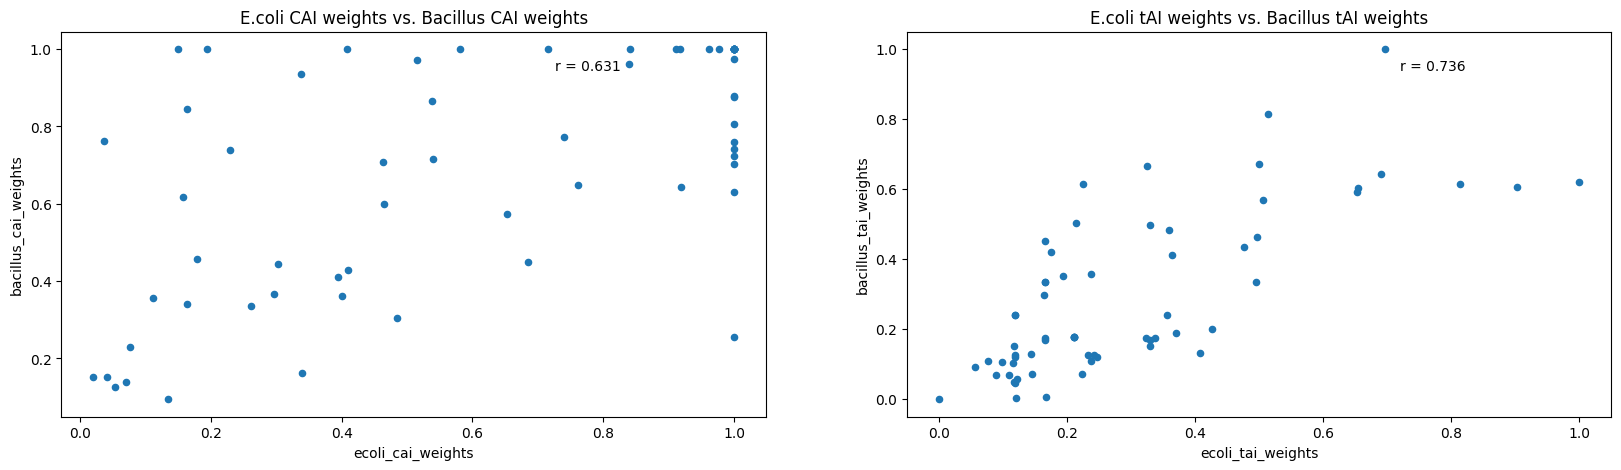

In [52]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
scatter = weights_dataframe.plot.scatter(x="ecoli_cai_weights", y="bacillus_cai_weights", title="E.coli CAI weights vs. Bacillus CAI weights", ax=axes[0])
r, p = stats.pearsonr(weights_dataframe["ecoli_cai_weights"], weights_dataframe["bacillus_cai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = weights_dataframe.plot.scatter(x="ecoli_tai_weights", y="bacillus_tai_weights", title="E.coli tAI weights vs. Bacillus tAI weights", ax=axes[1])
r, p = stats.pearsonr(weights_dataframe["ecoli_tai_weights"], weights_dataframe["bacillus_tai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.341')

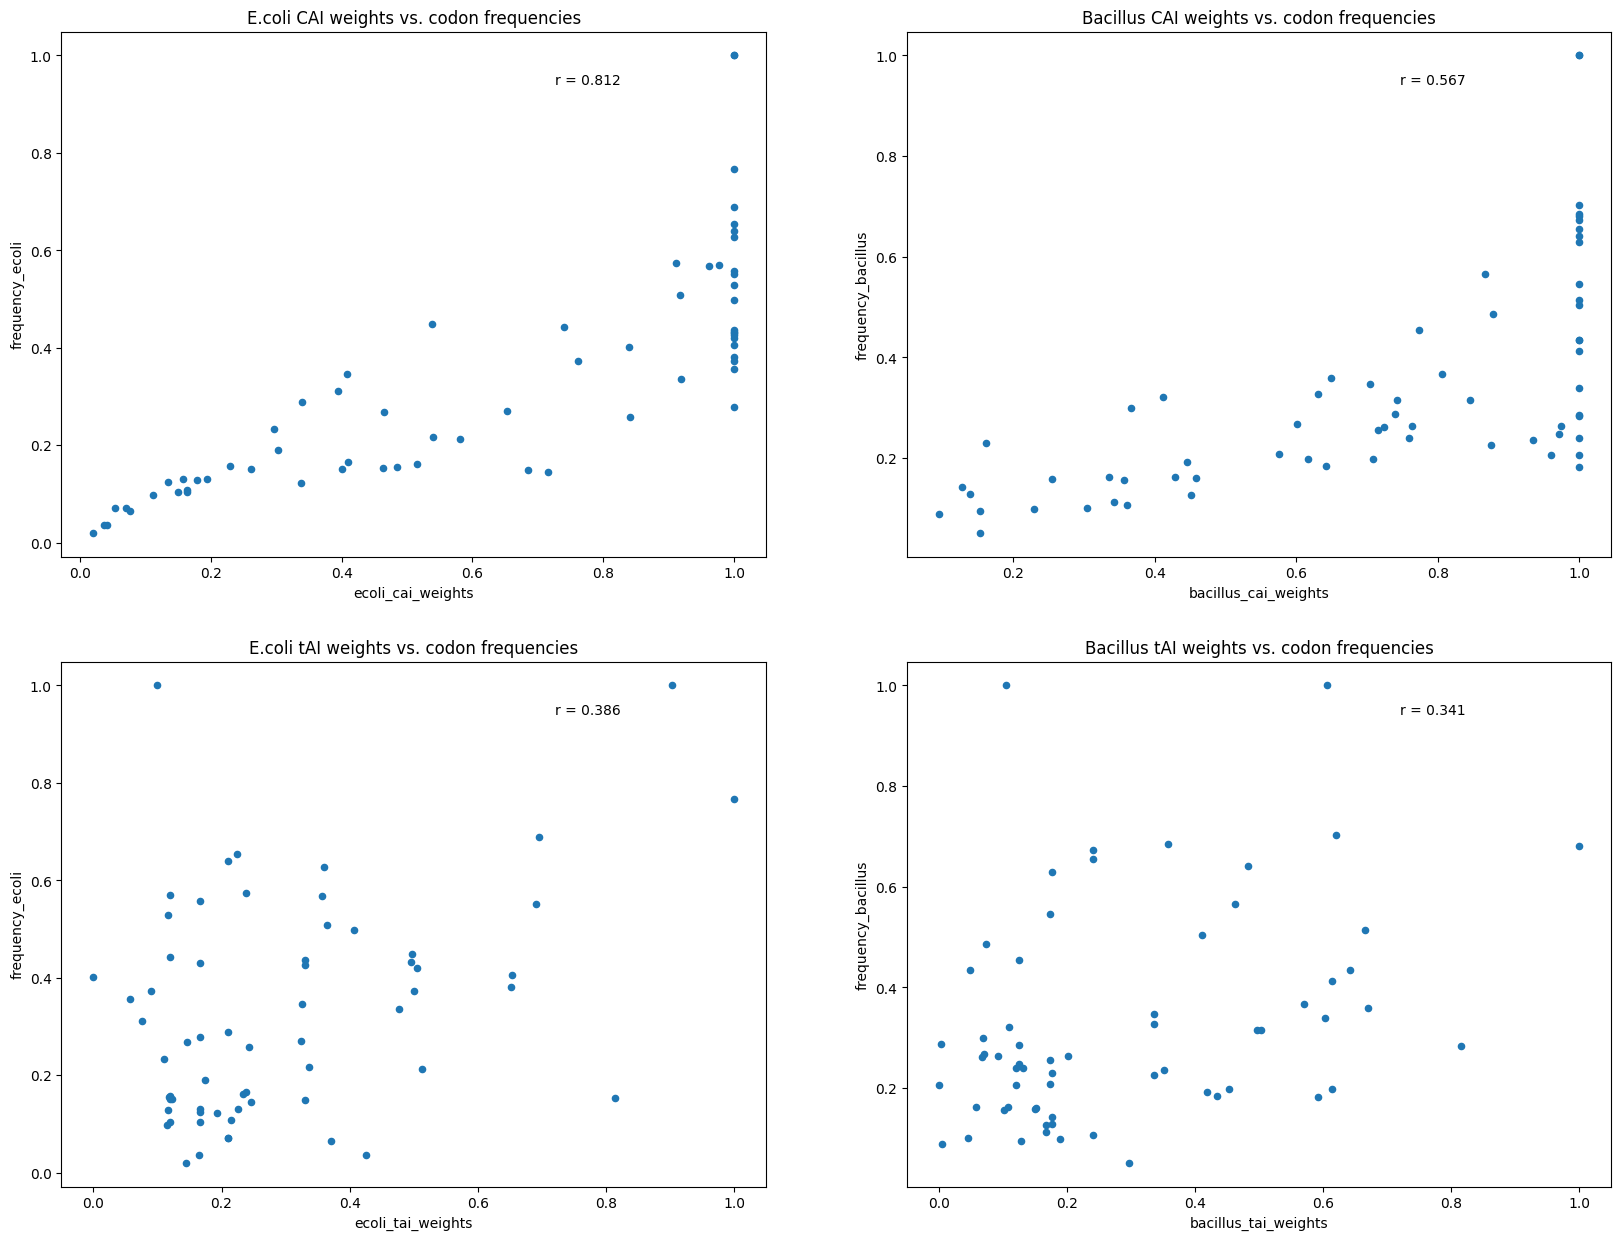

In [49]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies", ax=axes[0,0])
r, p = stats.pearsonr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies", ax=axes[0,1])
r, p = stats.pearsonr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies", ax=axes[1,0])
r, p = stats.pearsonr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies", ax=axes[1,1])
r, p = stats.pearsonr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

# Verification of variants translation to correct amino acid sequence

Validating original mcherry sequence:

In [18]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [19]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

# Verification of variants scores 

#### Eucledean distance of codon frequencies

In [22]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

In [23]:
# plot_frequency_map(original_mcherry_codon_frequencies)

In [24]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

In [25]:
df_dict = get_variants_df_dict(mcherry_variants_file)
ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe = pd.DataFrame(ecoli_opt_df_dict)

bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe = pd.DataFrame(bacillus_opt_df_dict)

# fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,35))
# fig.suptitle("Codon frequencies distances - optimized E.coli")
# my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 

# for q in range(ecoli_opt_variants_dataframe.shape[0]):
#     ax = axes[q // 4,  q % 4]
#     ax.set_title(ecoli_opt_variants_dataframe.iloc[q,0])
#     ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=ax, stacked=True, color=my_colors)

#### Gene CUB scores

In [35]:
df_dict = get_cub_score_df_dict(mcherry_root_dir)
cub_ecoli_opt_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_variants_dataframe = pd.DataFrame(cub_ecoli_opt_df_dict)

evaluation_ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_df_dict)

cub_bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_variants_dataframe = pd.DataFrame(cub_bacillus_opt_df_dict)

evaluation_bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_df_dict)

# fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,20))
# fig.suptitle("CUB scores for optimized E.coli")
# my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 

# for q in range(cub_ecoli_opt_variants_dataframe.shape[0]):
#     ax = axes[q // 4,  q % 4]
    
#     ax.set_title(cub_ecoli_opt_variants_dataframe.iloc[q,0])
#     cub_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=ax, stacked=True, color=my_colors)


#### Single organism -  Eucledean distance of codon frequencies

In [29]:
greater_alpha_df_dict = get_variants_df_dict(mcherry_greater_alpha_variants_file)
    
greater_alpha_ecoli_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(greater_alpha_ecoli_opt_df_dict)

greater_alpha_bacillus_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(greater_alpha_bacillus_opt_df_dict)

# fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,20))
# my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 

# for q in range(greater_alpha_ecoli_opt_variants_dataframe.shape[0]):
#     ax = axes[q // 4,  q % 4]
#     ax.set_title(greater_alpha_ecoli_opt_variants_dataframe.iloc[q,0])
#     greater_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=ax, stacked=True, color=my_colors)

#### Single organism -  CUB scores

In [31]:
greater_alpha_df_dict = get_cub_score_df_dict(mcherry_greater_alpha_root_dir)
cub_ecoli_opt_greater_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key == "evaluation_score")}
cub_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_greater_alpha_df_dict)

cub_bacillus_opt_greater_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key == "evaluation_score")}
cub_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_greater_alpha_df_dict)


# fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,20))
# fig.suptitle("CUB scores for optimized E.coli")
# my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 

# for q in range(cub_ecoli_opt_greater_alpha_variants_dataframe.shape[0]):
#     ax = axes[q // 4,  q % 4]
    
#     ax.set_title(cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,0])
#     cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=ax, stacked=True, color=my_colors)

# Comparative analysis: Optimizing for a single organism vs. suggested method

## Optimizing for E.coli

<AxesSubplot:ylabel='variant'>

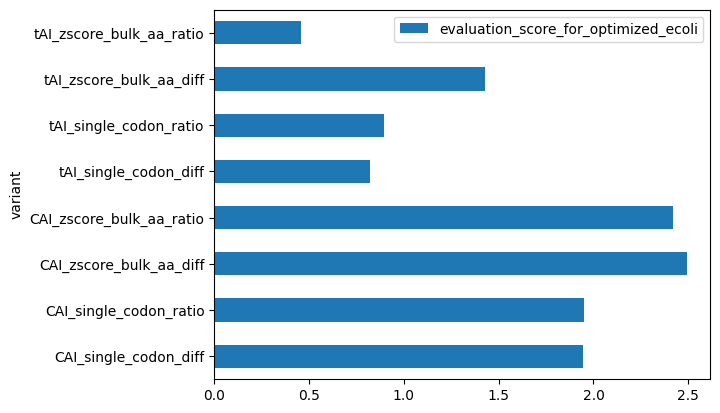

In [57]:
evaluation_ecoli_opt_variants_dataframe.plot("variant", kind="barh")

Text(0.7, 0.9, 'r = 0.931')

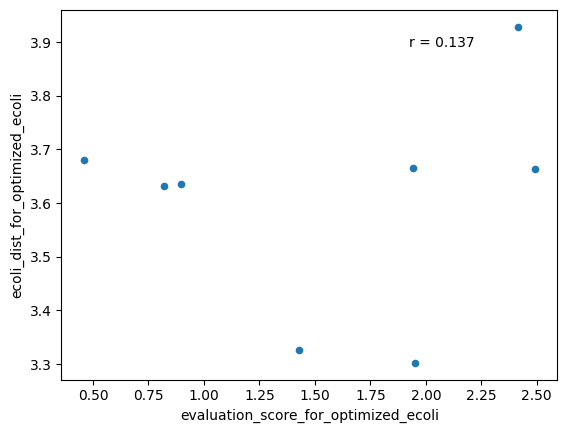

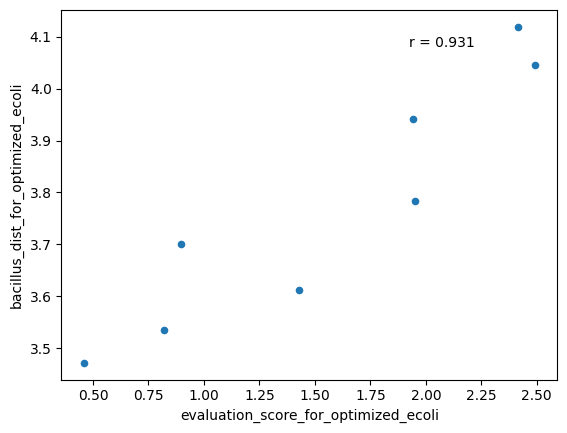

In [64]:
merged_df = pd.merge(evaluation_ecoli_opt_variants_dataframe, ecoli_opt_variants_dataframe, on='variant', how='inner')
# merged_df['ecoli_dist_diff'] = merged_df['ecoli_dist_for_original_mcherry'] - merged_df['ecoli_dist_for_optimized_ecoli']
# merged_df['bacillus_dist_diff'] = merged_df['bacillus_dist_for_original_mcherry'] - merged_df['bacillus_dist_for_optimized_ecoli']

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_dist_for_optimized_ecoli")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["ecoli_dist_for_optimized_ecoli"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_dist_for_optimized_ecoli")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["bacillus_dist_for_optimized_ecoli"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.814')

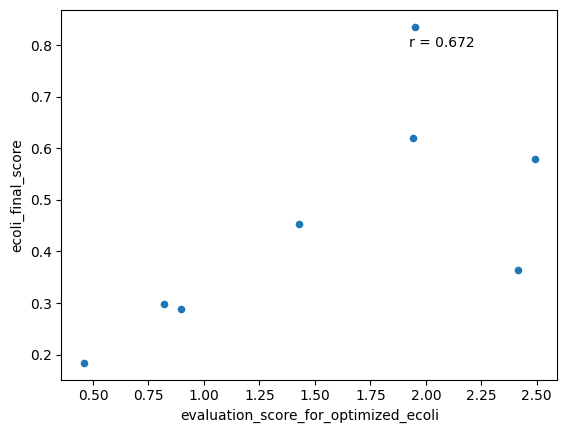

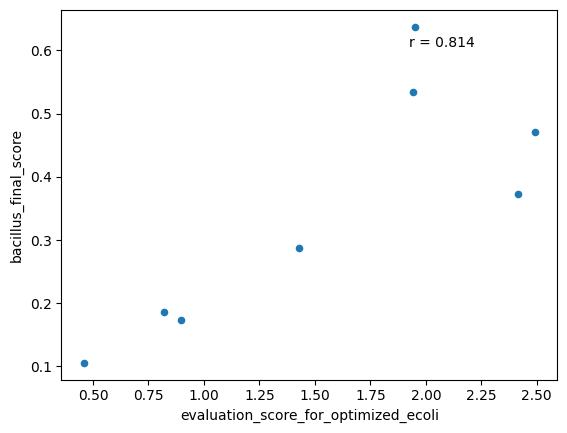

In [66]:
merged_df = pd.merge(evaluation_ecoli_opt_variants_dataframe, cub_ecoli_opt_variants_dataframe, on='variant', how='inner')
# merged_df['ecoli_dist_diff'] = merged_df['ecoli_dist_for_original_mcherry'] - merged_df['ecoli_dist_for_optimized_ecoli']
# merged_df['bacillus_dist_diff'] = merged_df['bacillus_dist_for_original_mcherry'] - merged_df['bacillus_dist_for_optimized_ecoli']

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_final_score")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["ecoli_final_score"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_final_score")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["bacillus_final_score"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [68]:
cub_ecoli_opt_greater_alpha_variants_dataframe

,variant,ecoli_initial_score,ecoli_final_score,bacillus_initial_score,bacillus_final_score
0,CAI_single_codon_diff,0.805490,1.000000,0.776047,0.836829
1,CAI_single_codon_ratio,0.805490,1.000000,0.776047,0.836829
2,CAI_zscore_bulk_aa_diff,0.805490,1.000000,0.776047,0.836829
3,CAI_zscore_bulk_aa_ratio,0.805490,1.000000,0.776047,0.836829
4,tAI_single_codon_diff,0.256867,0.506593,0.203052,0.479235
5,tAI_single_codon_ratio,0.256867,0.506593,0.203052,0.479235
6,tAI_zscore_bulk_aa_diff,0.256867,0.506593,0.203052,0.479235
7,tAI_zscore_bulk_aa_ratio,0.256867,0.506593,0.203052,0.479235


Text(0.7, 0.9, 'r = 0.906')

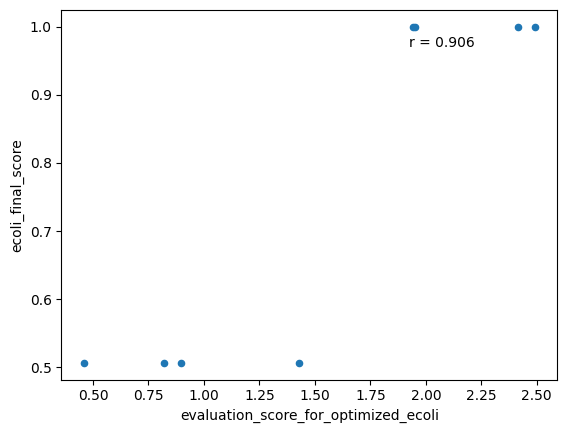

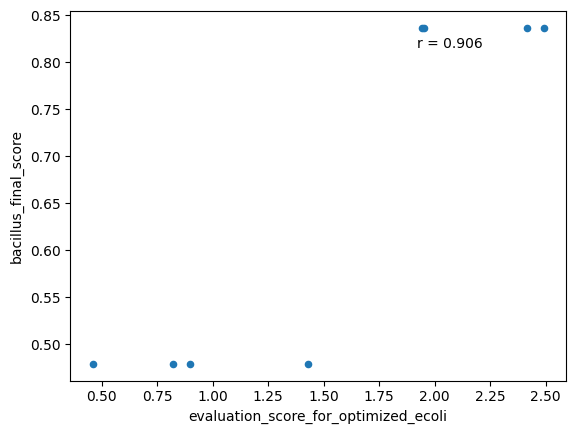

In [67]:
merged_df = pd.merge(evaluation_ecoli_opt_variants_dataframe, cub_ecoli_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
# merged_df['ecoli_dist_diff'] = merged_df['ecoli_dist_for_original_mcherry'] - merged_df['ecoli_dist_for_optimized_ecoli']
# merged_df['bacillus_dist_diff'] = merged_df['bacillus_dist_for_original_mcherry'] - merged_df['bacillus_dist_for_optimized_ecoli']

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_final_score")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["ecoli_final_score"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_final_score")
r, p = stats.pearsonr(merged_df["evaluation_score_for_optimized_ecoli"], merged_df["bacillus_final_score"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

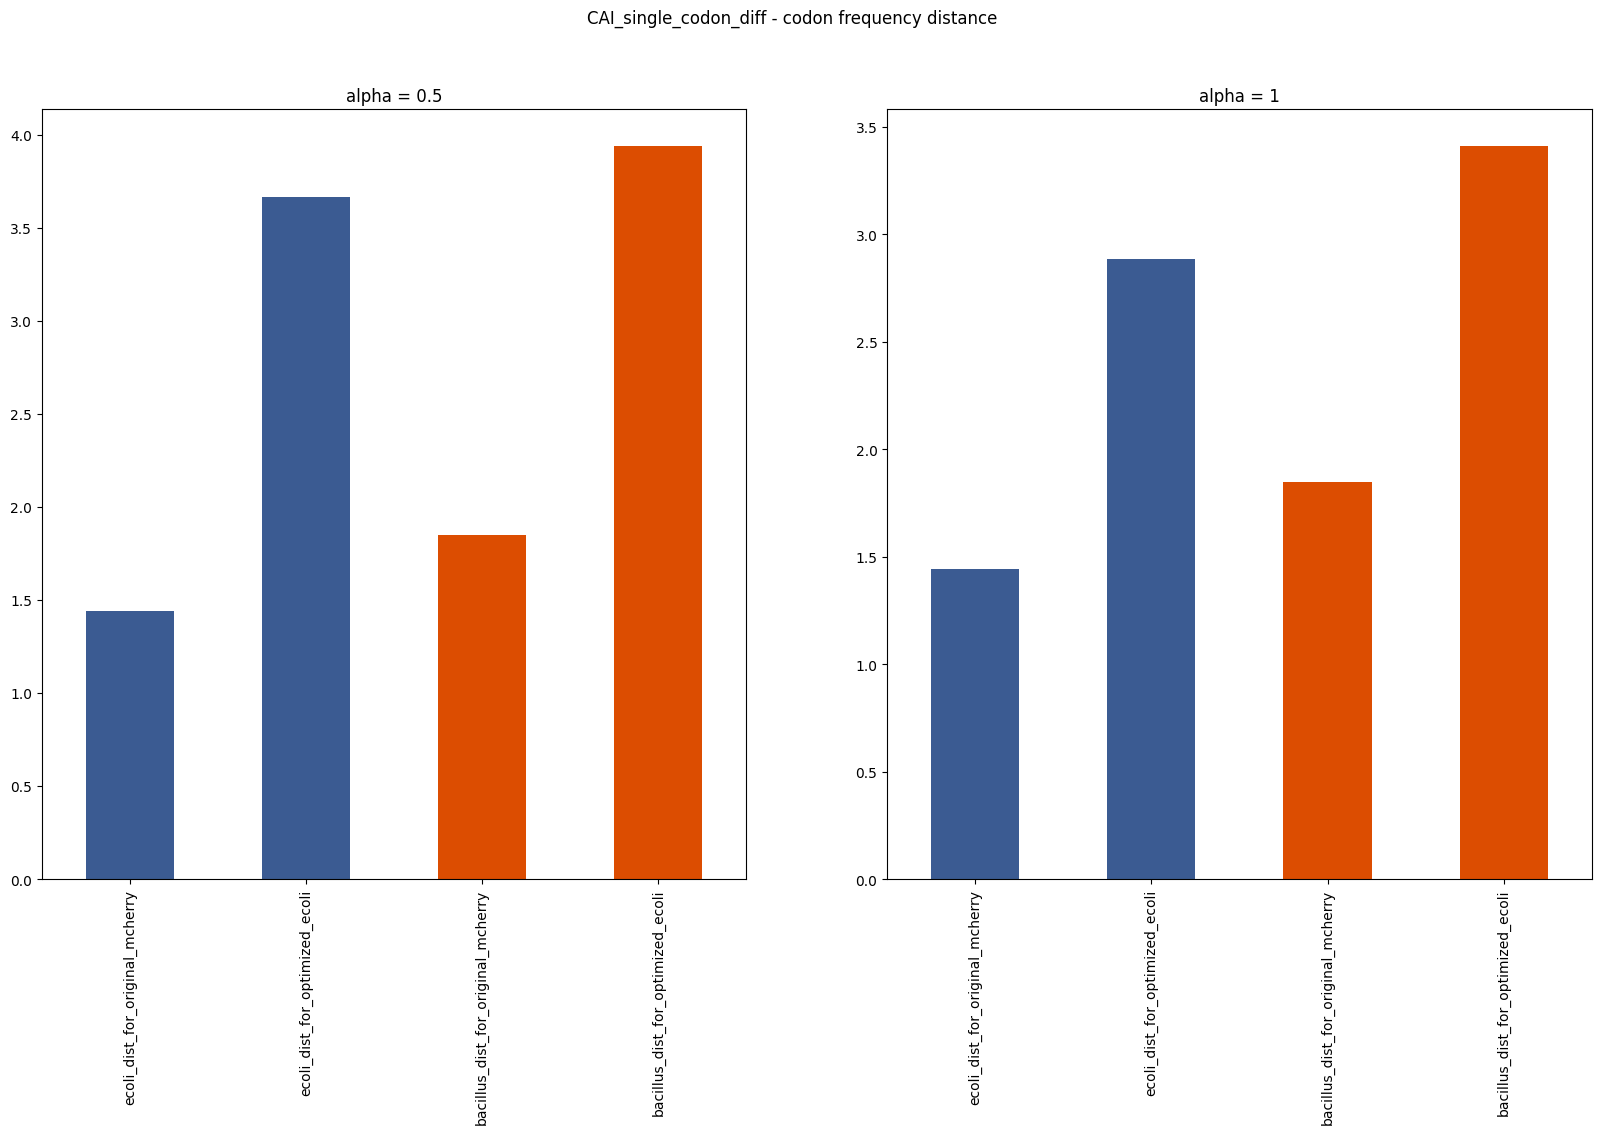

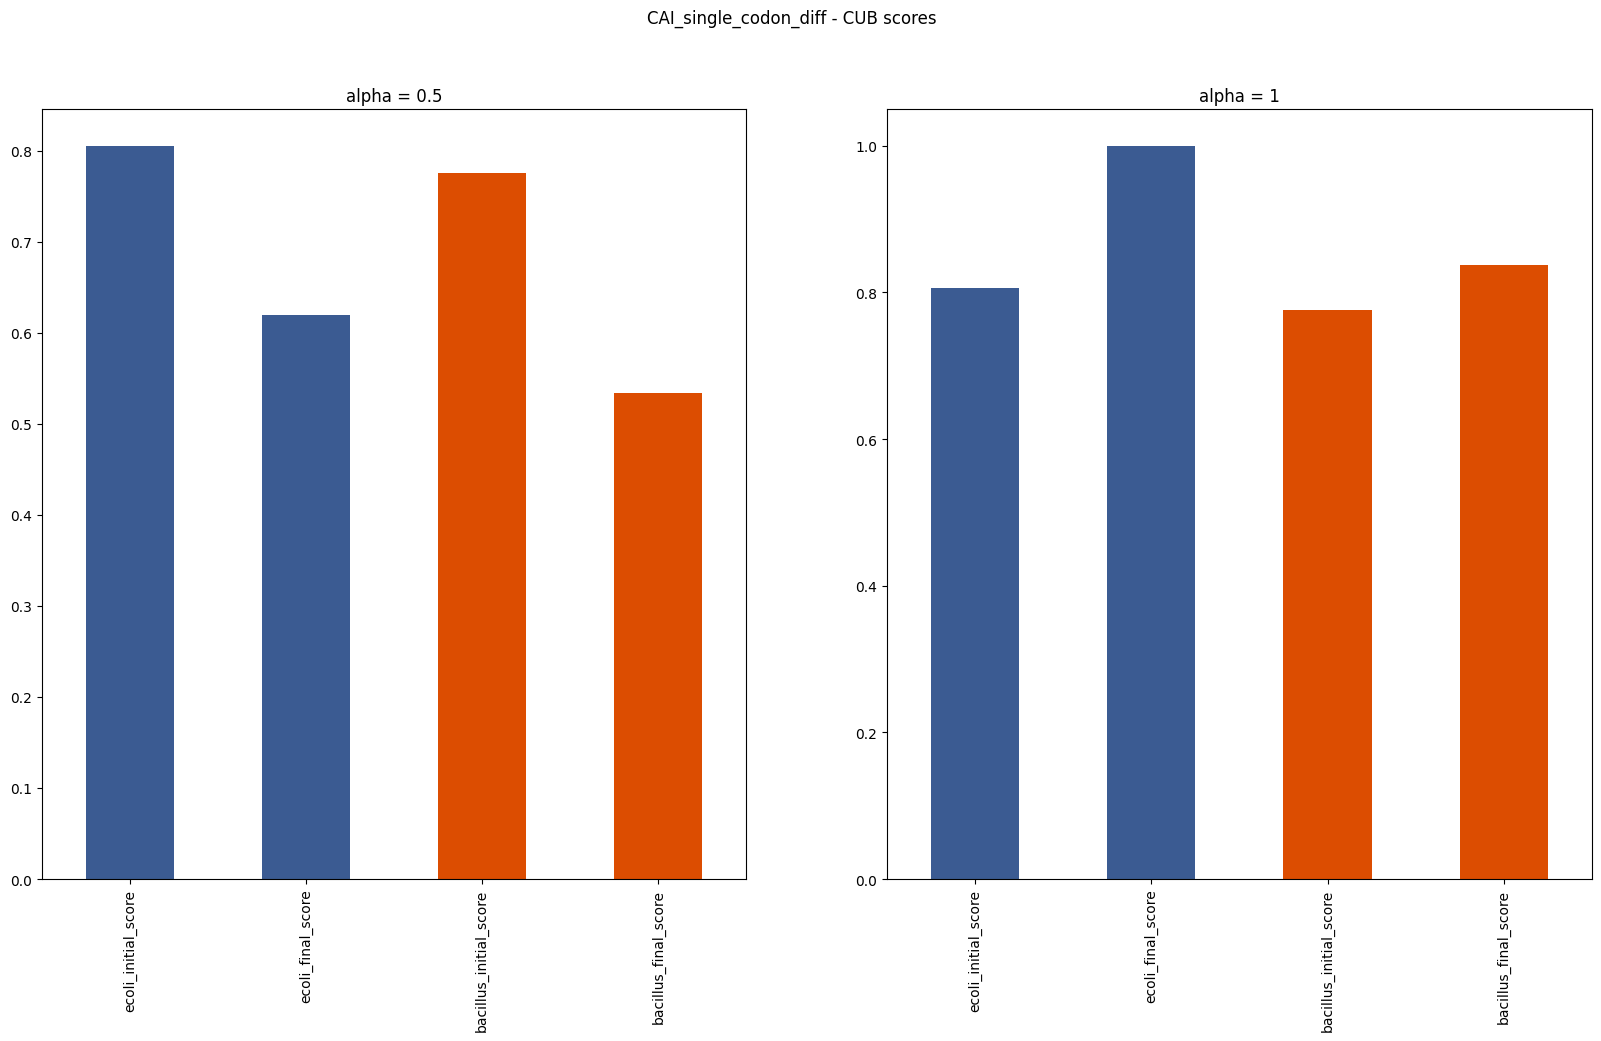

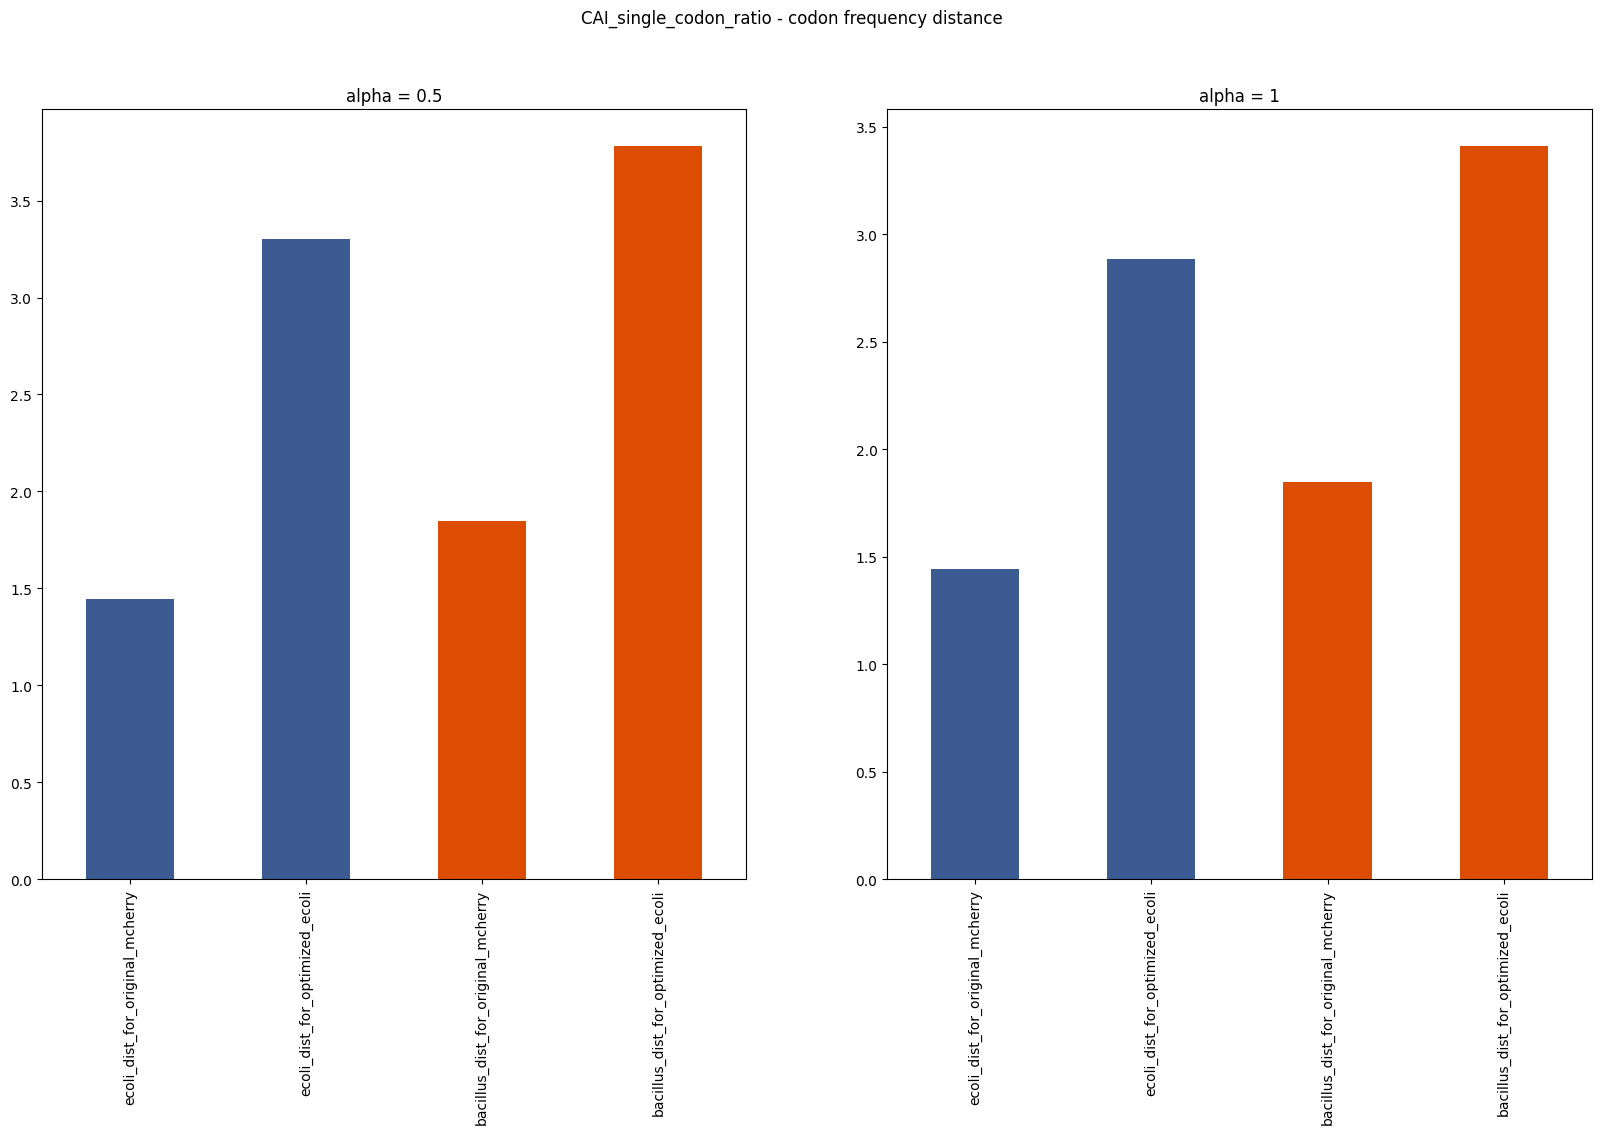

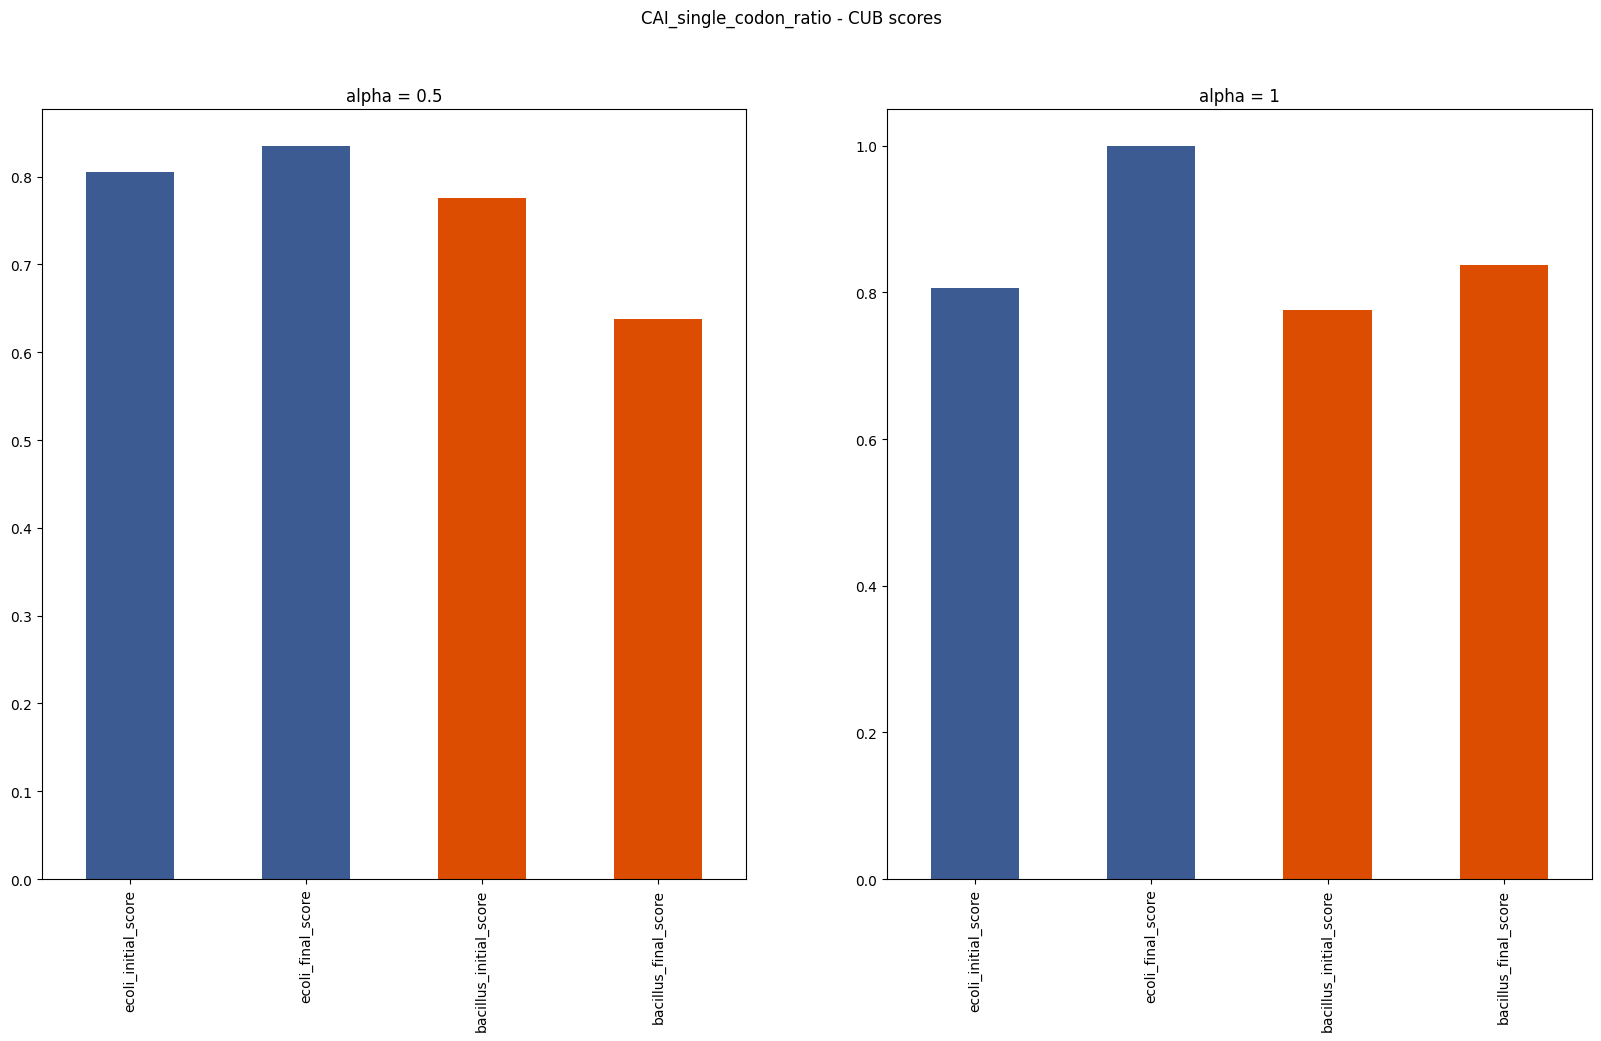

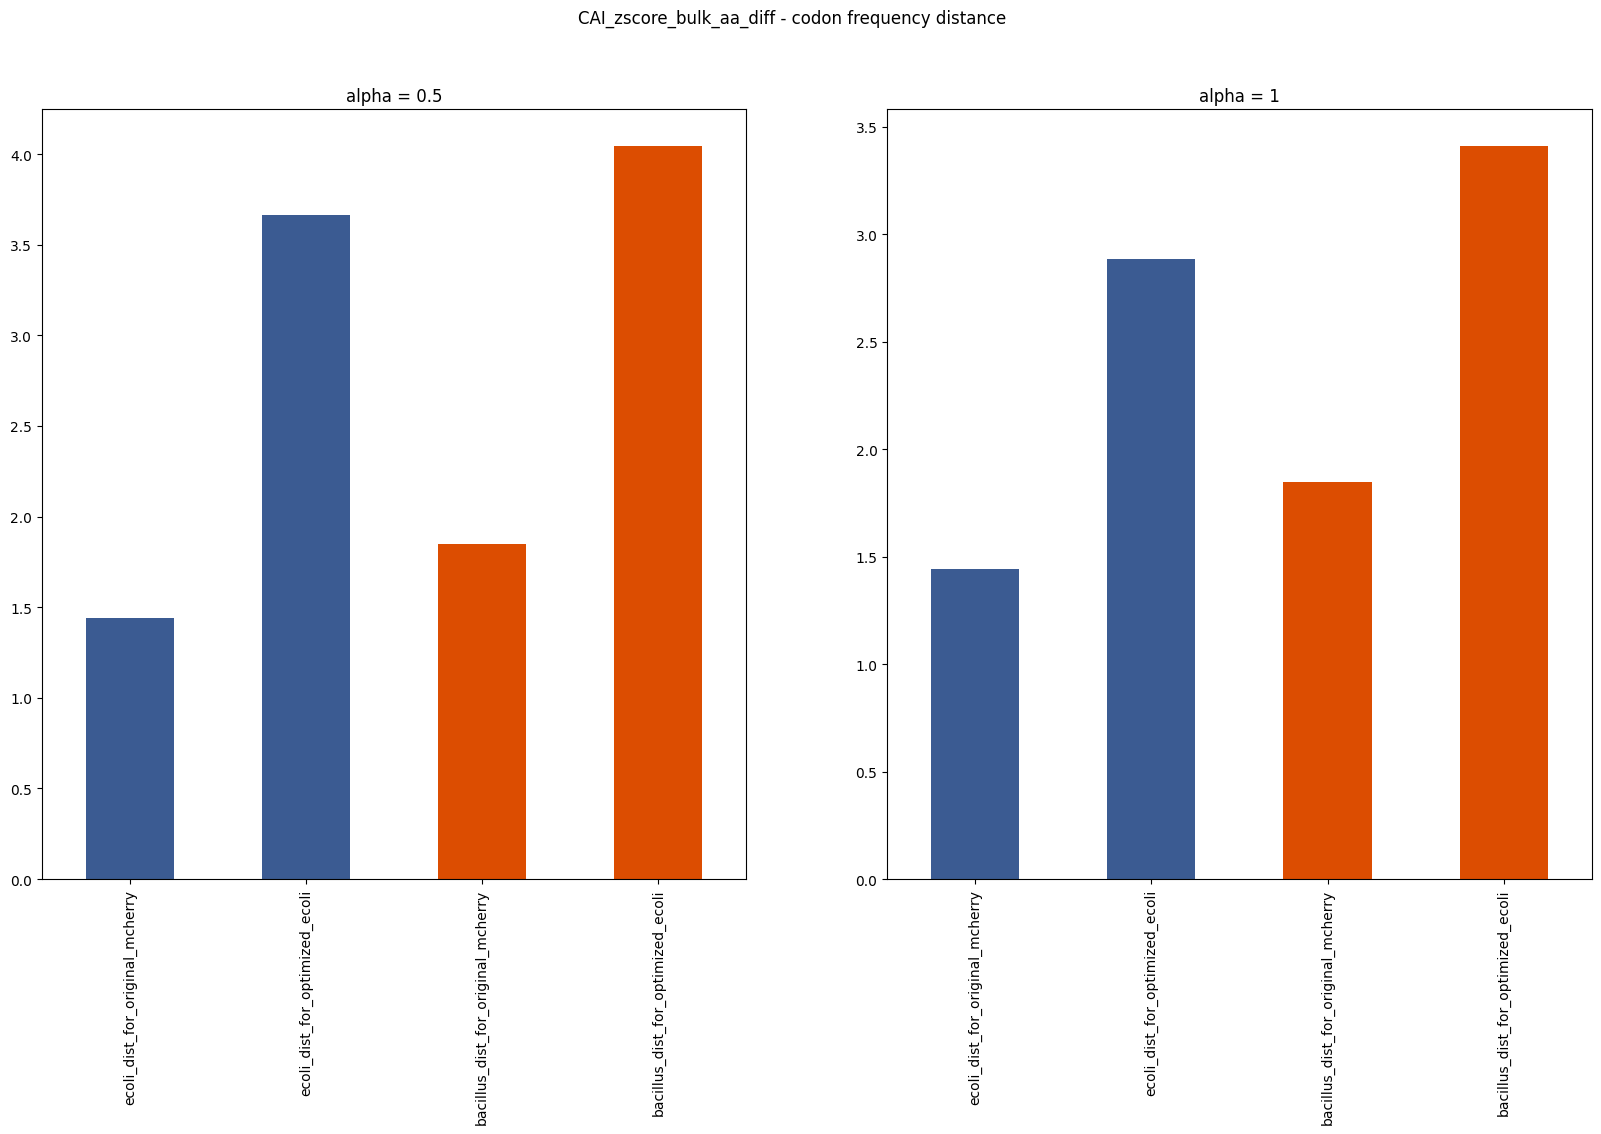

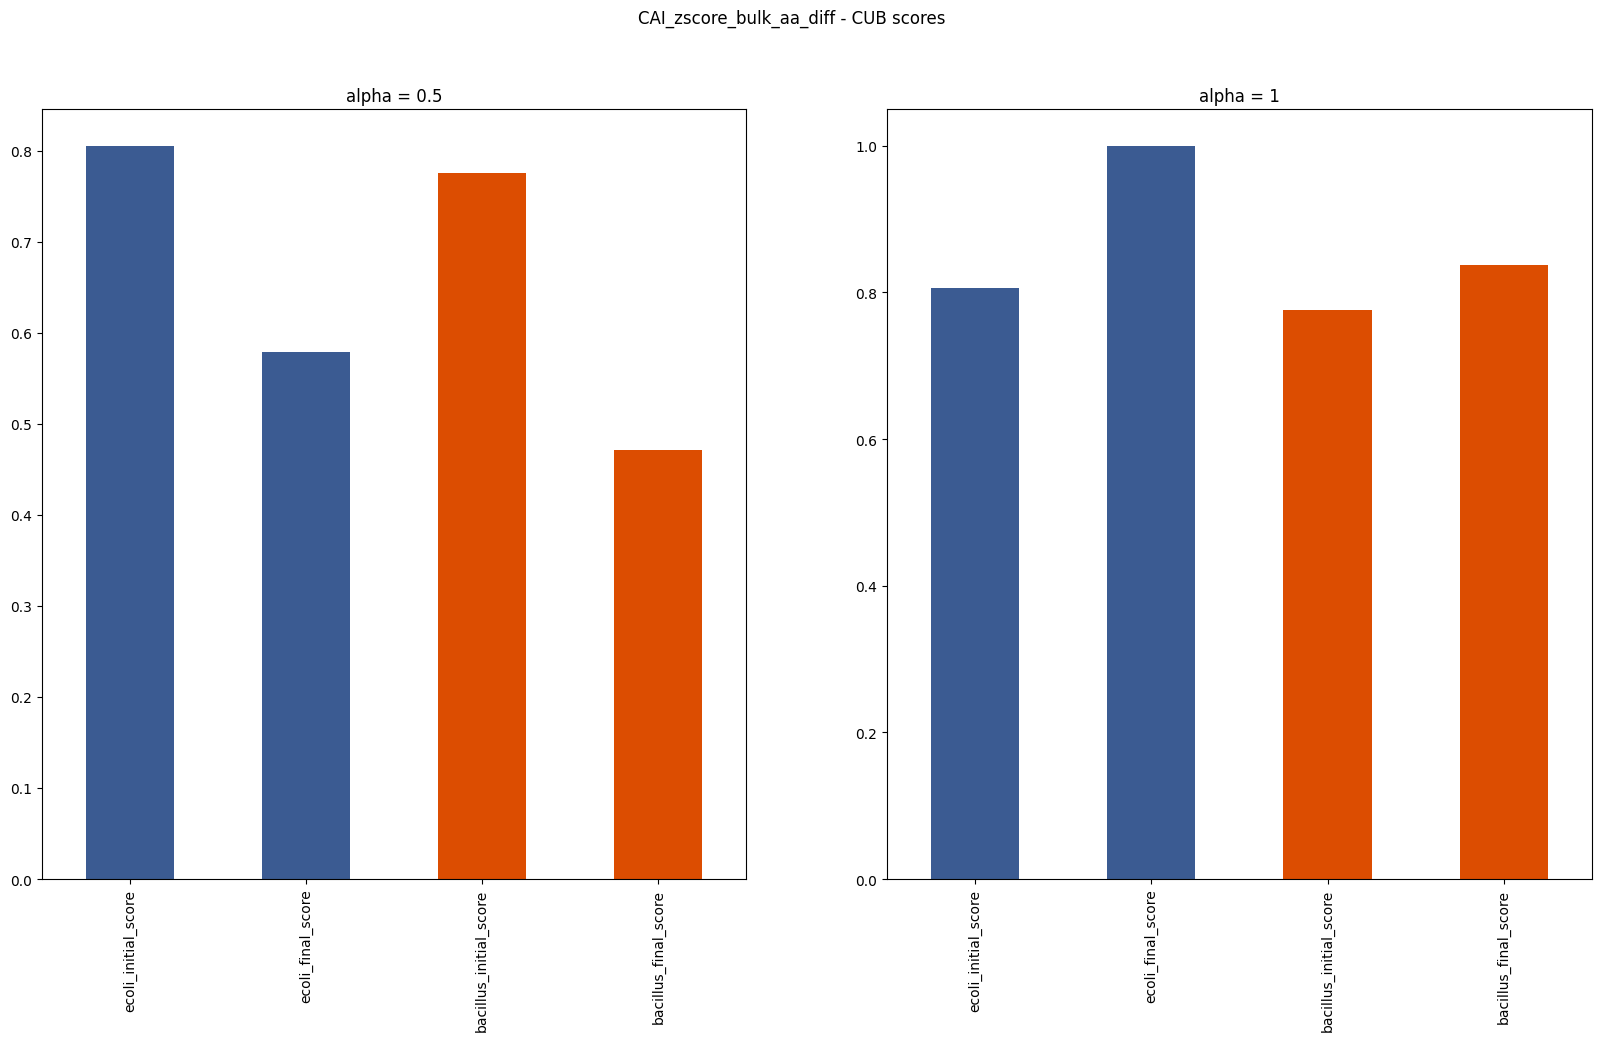

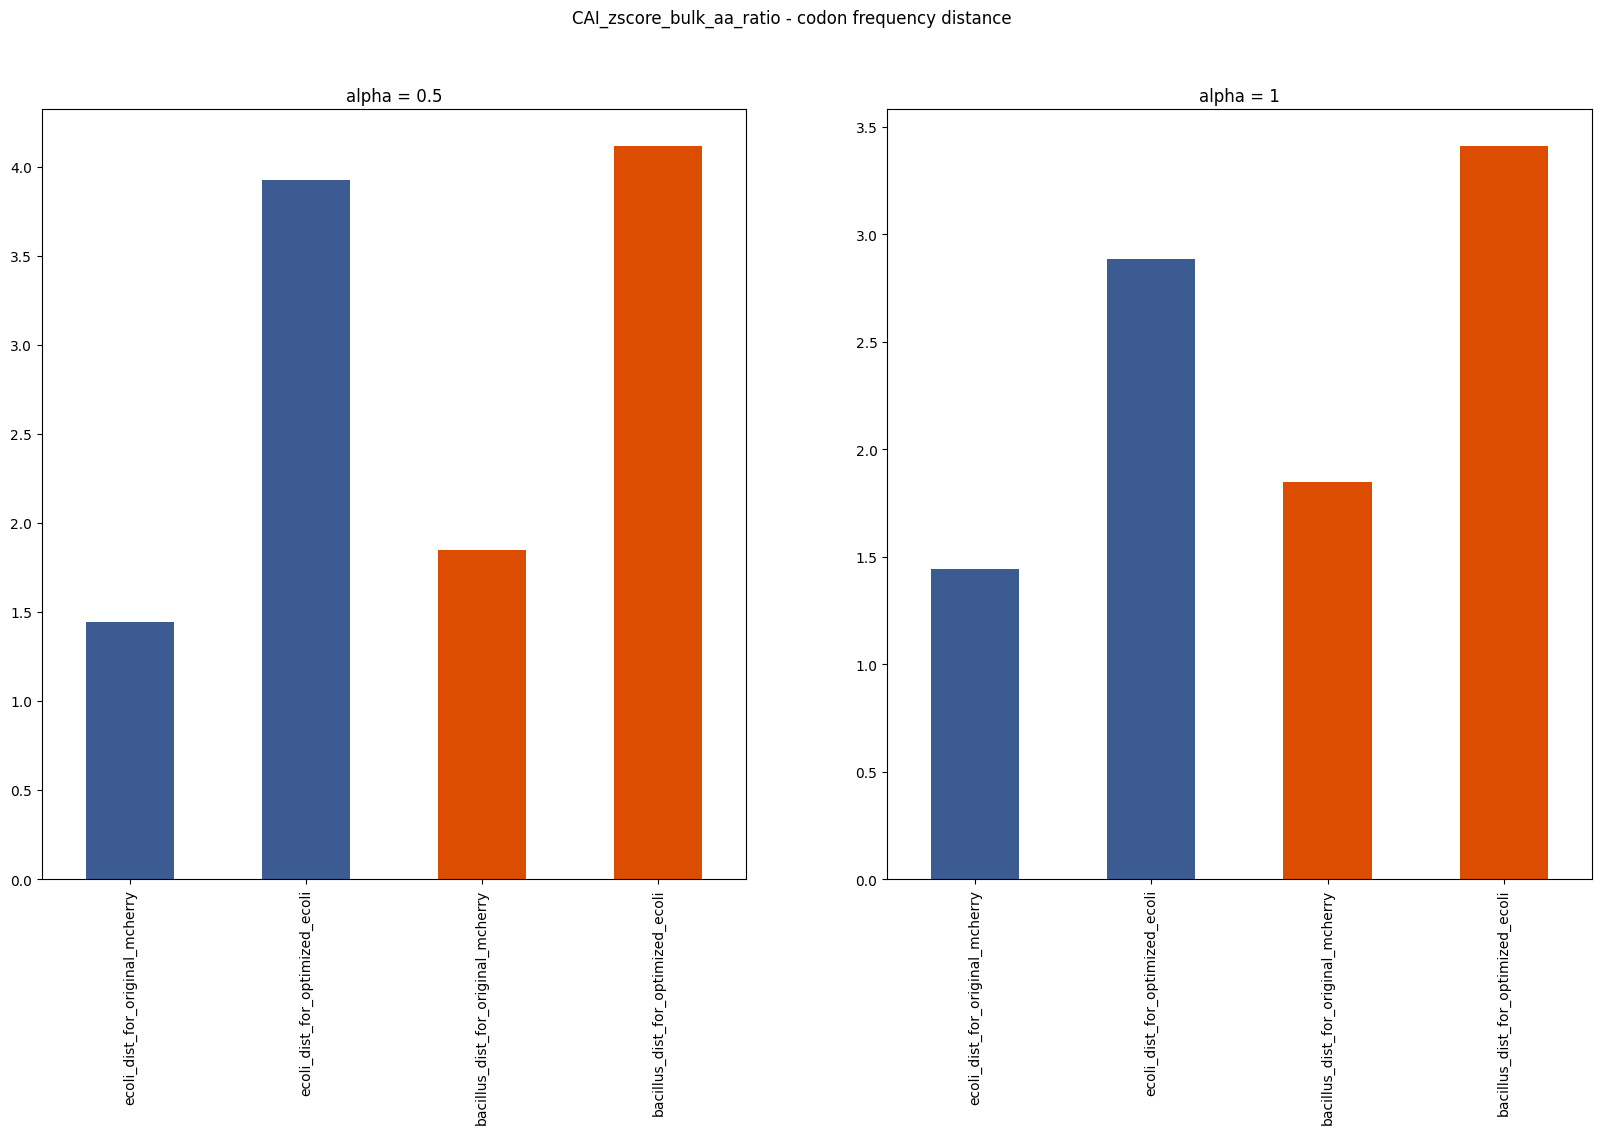

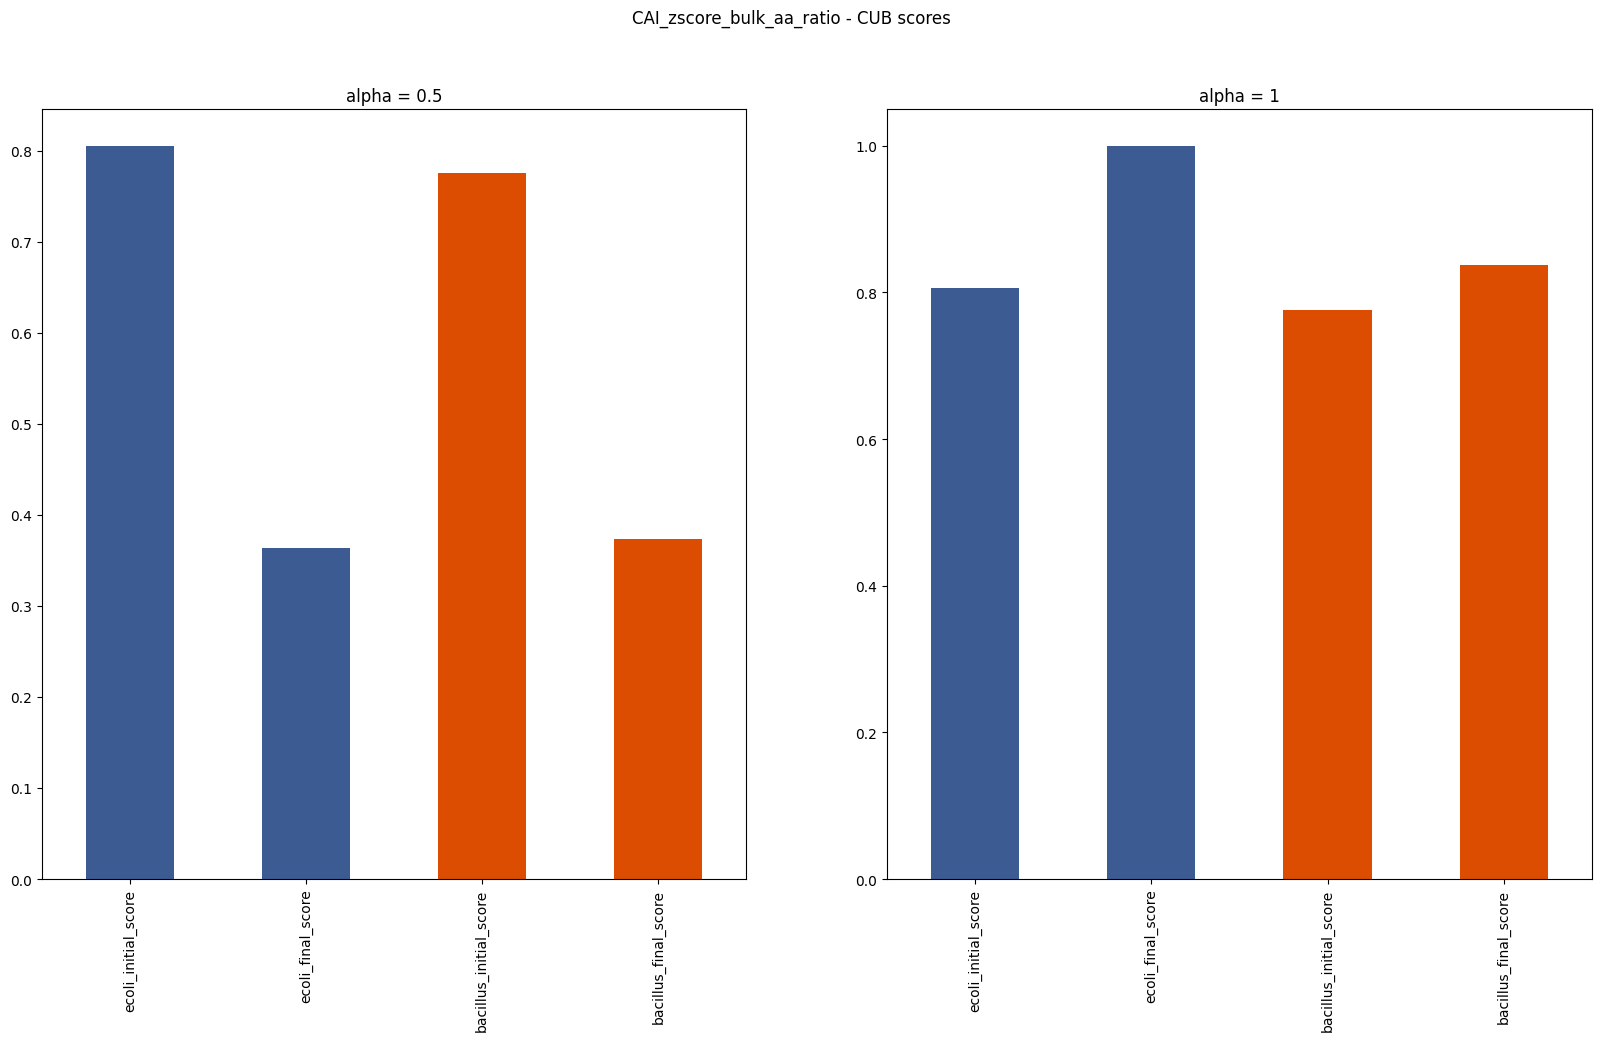

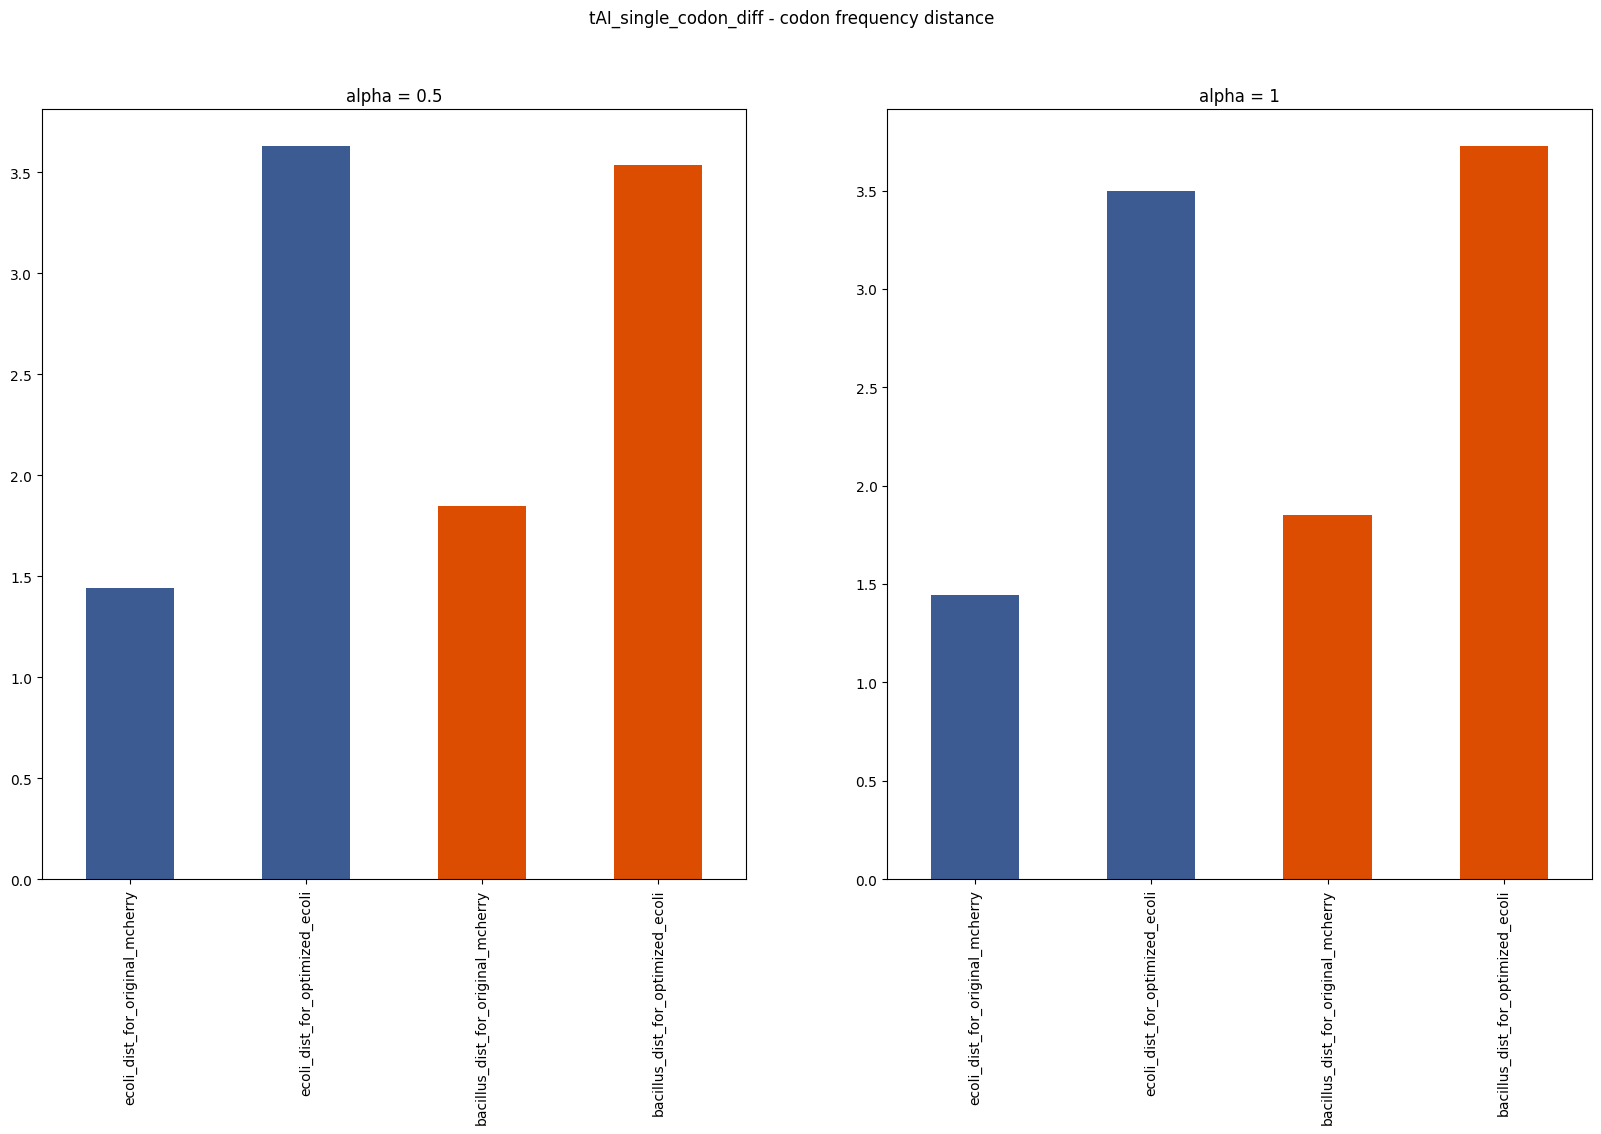

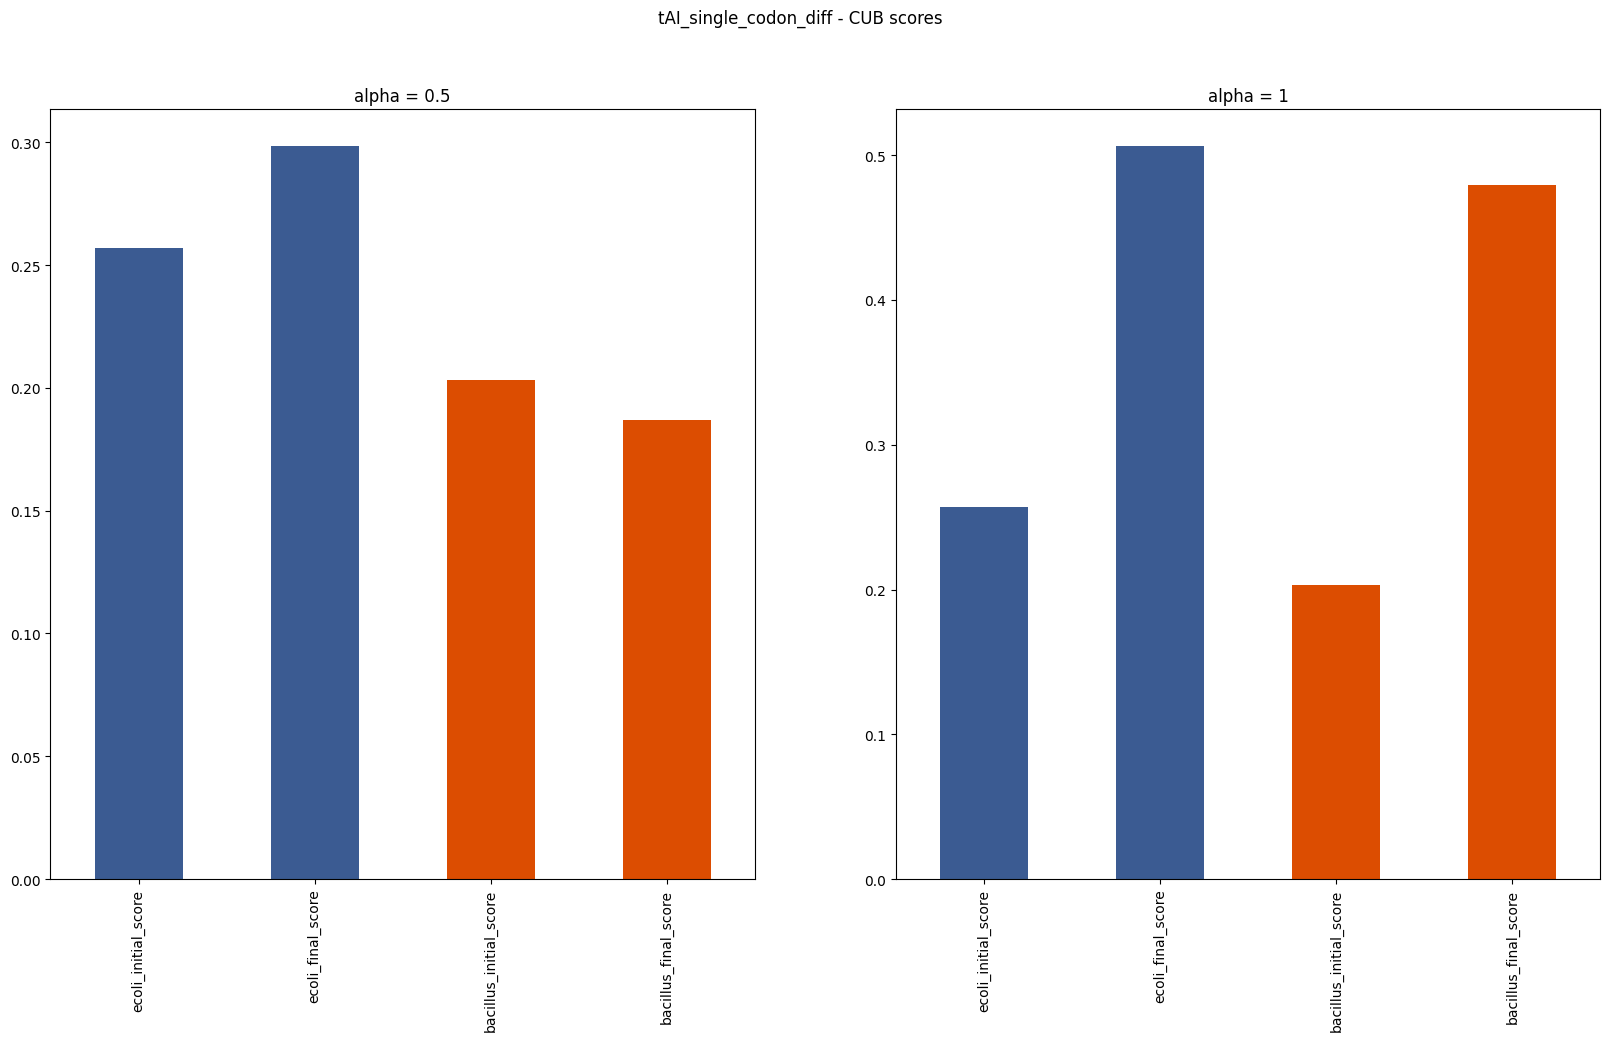

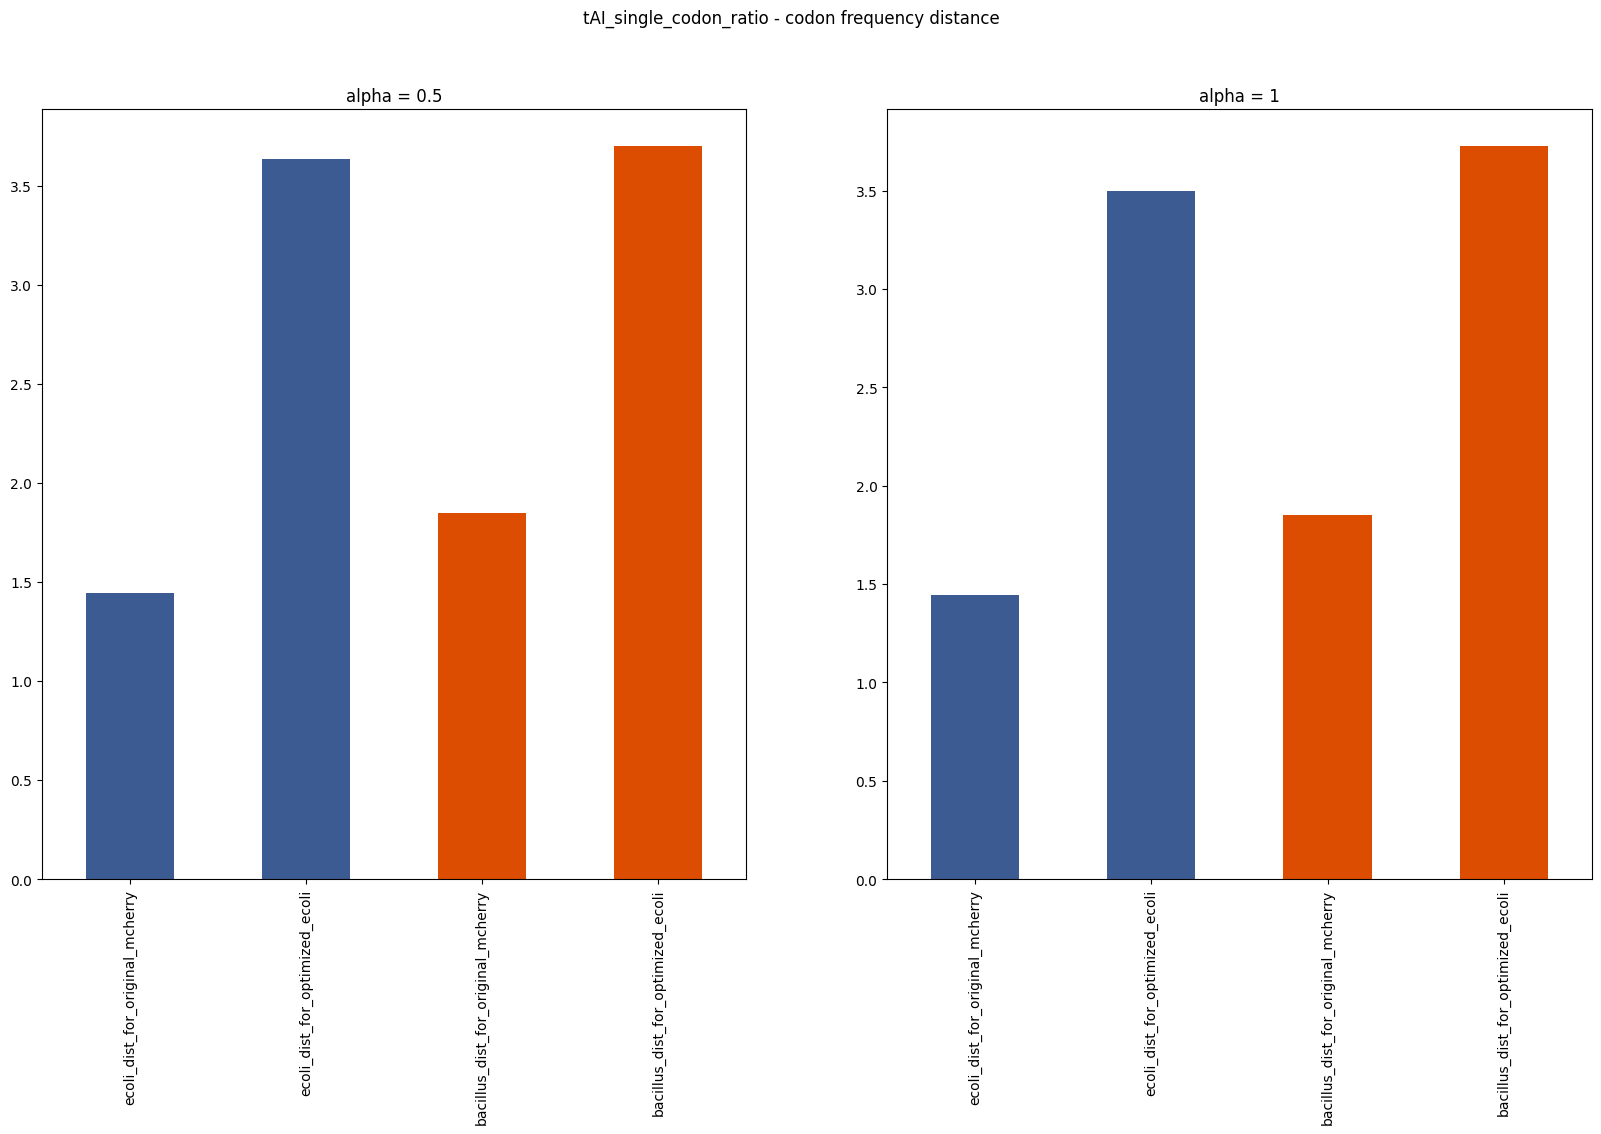

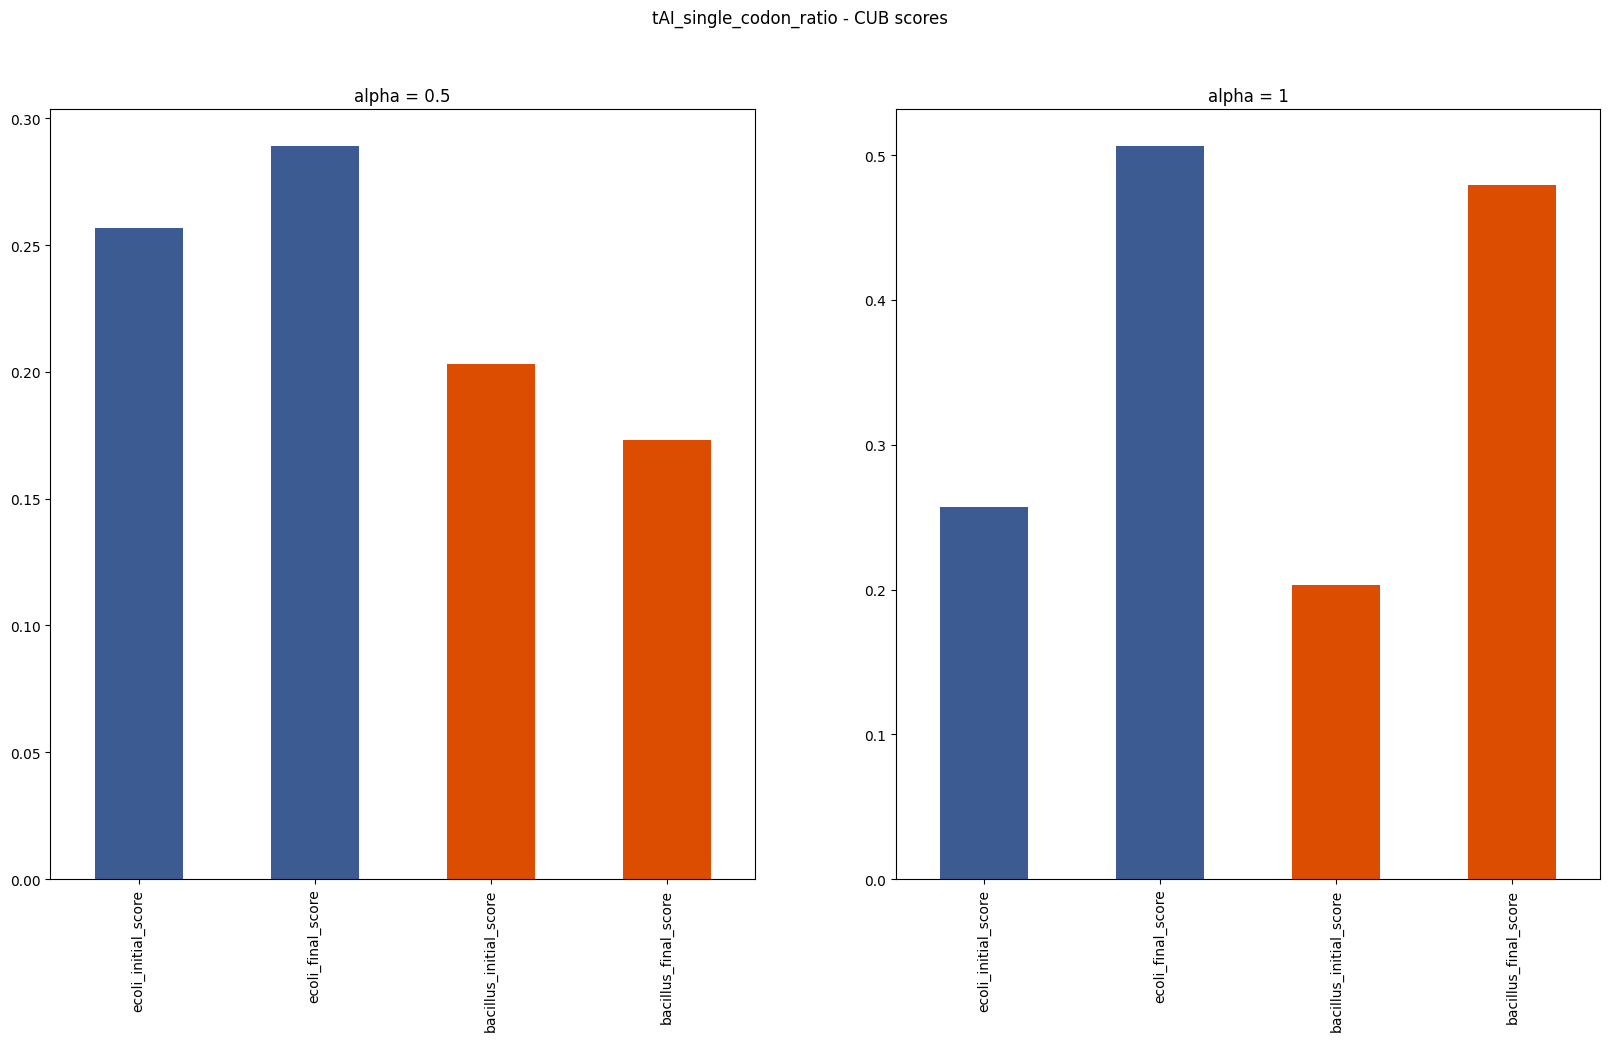

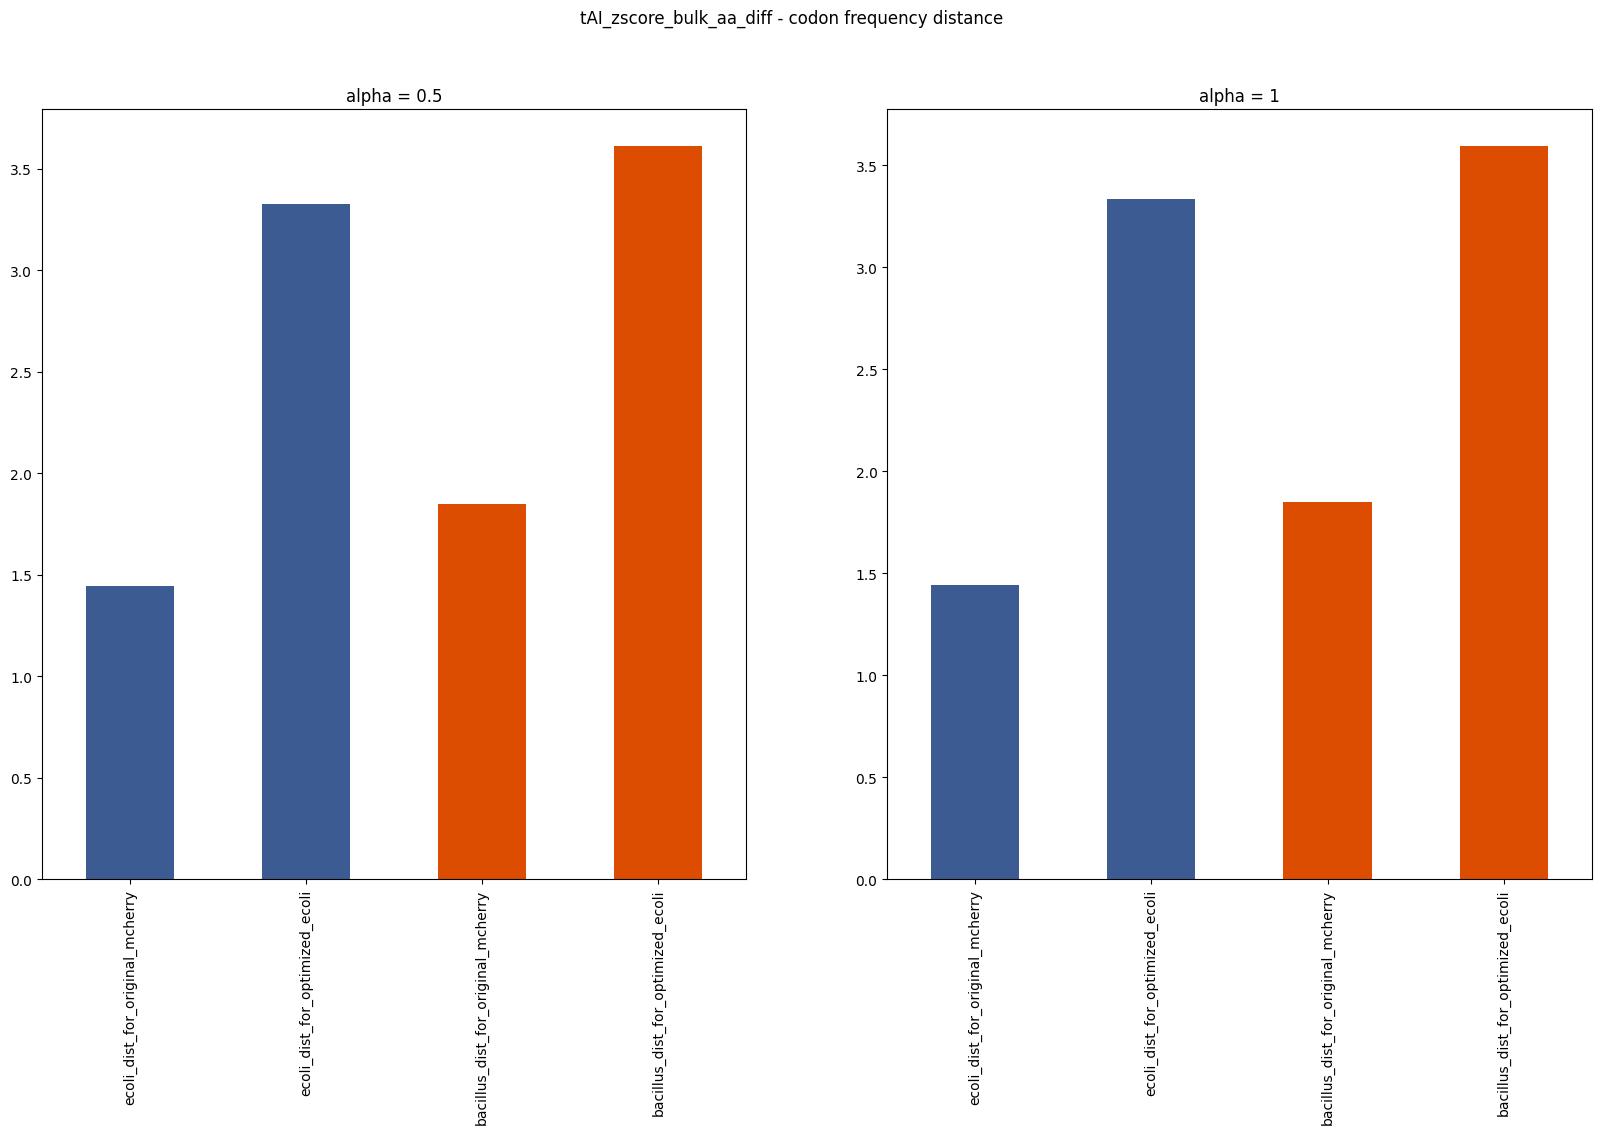

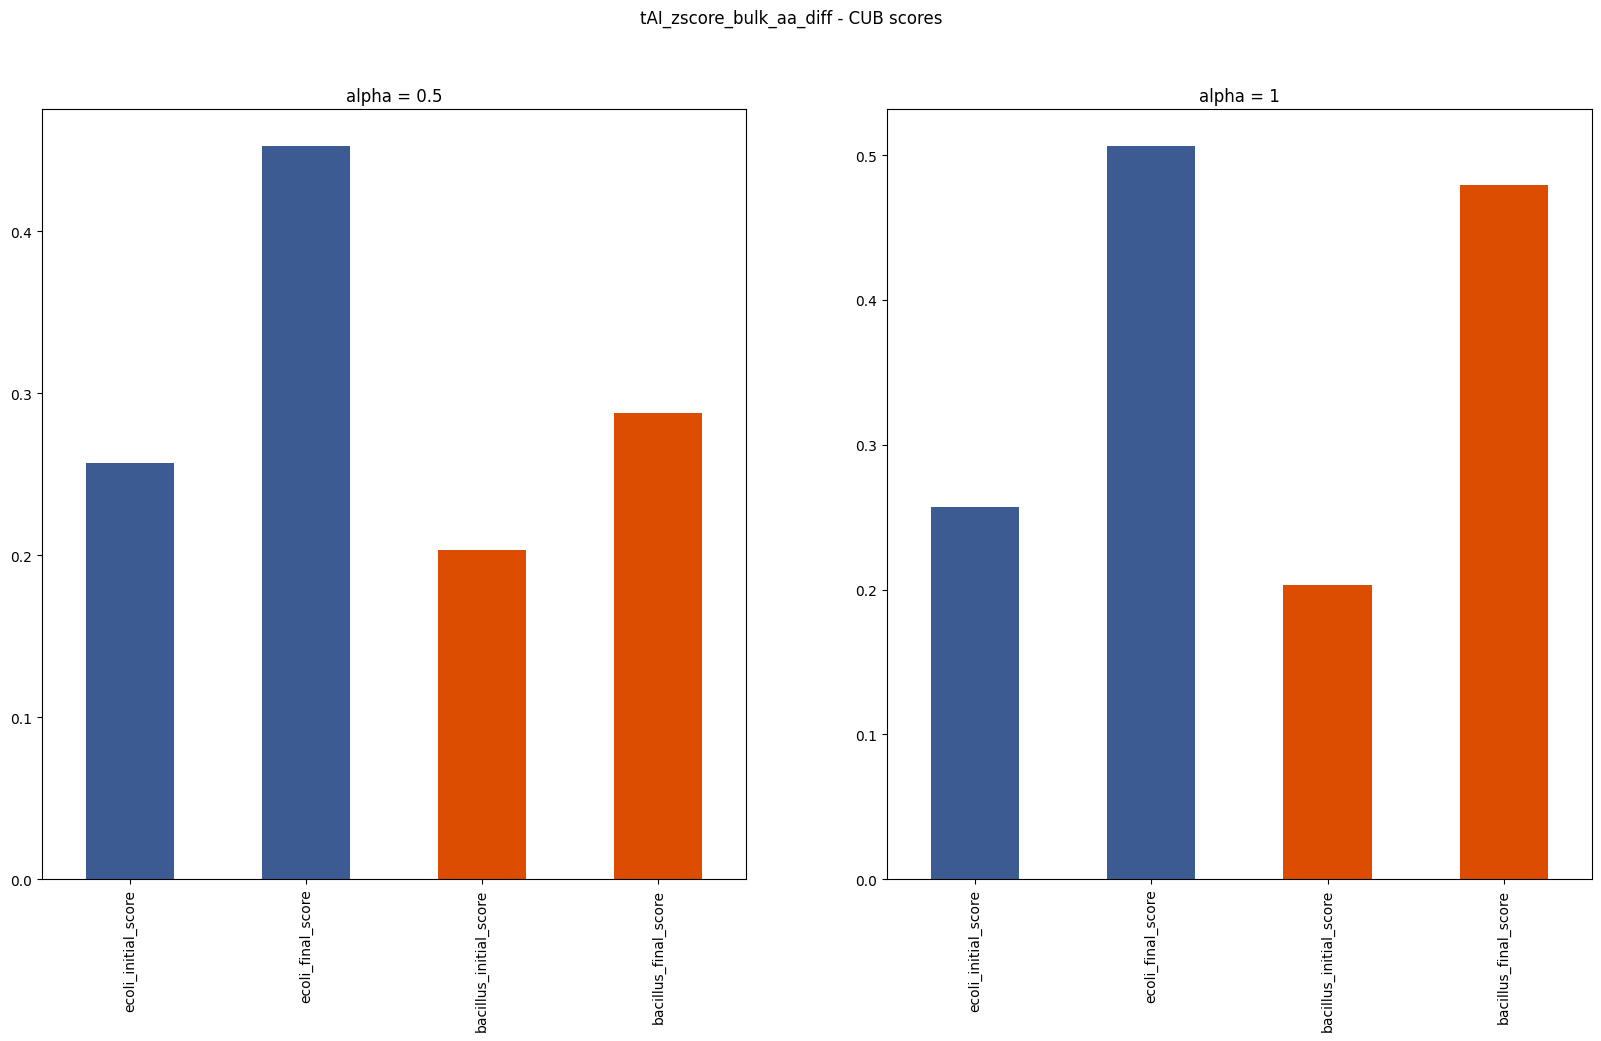

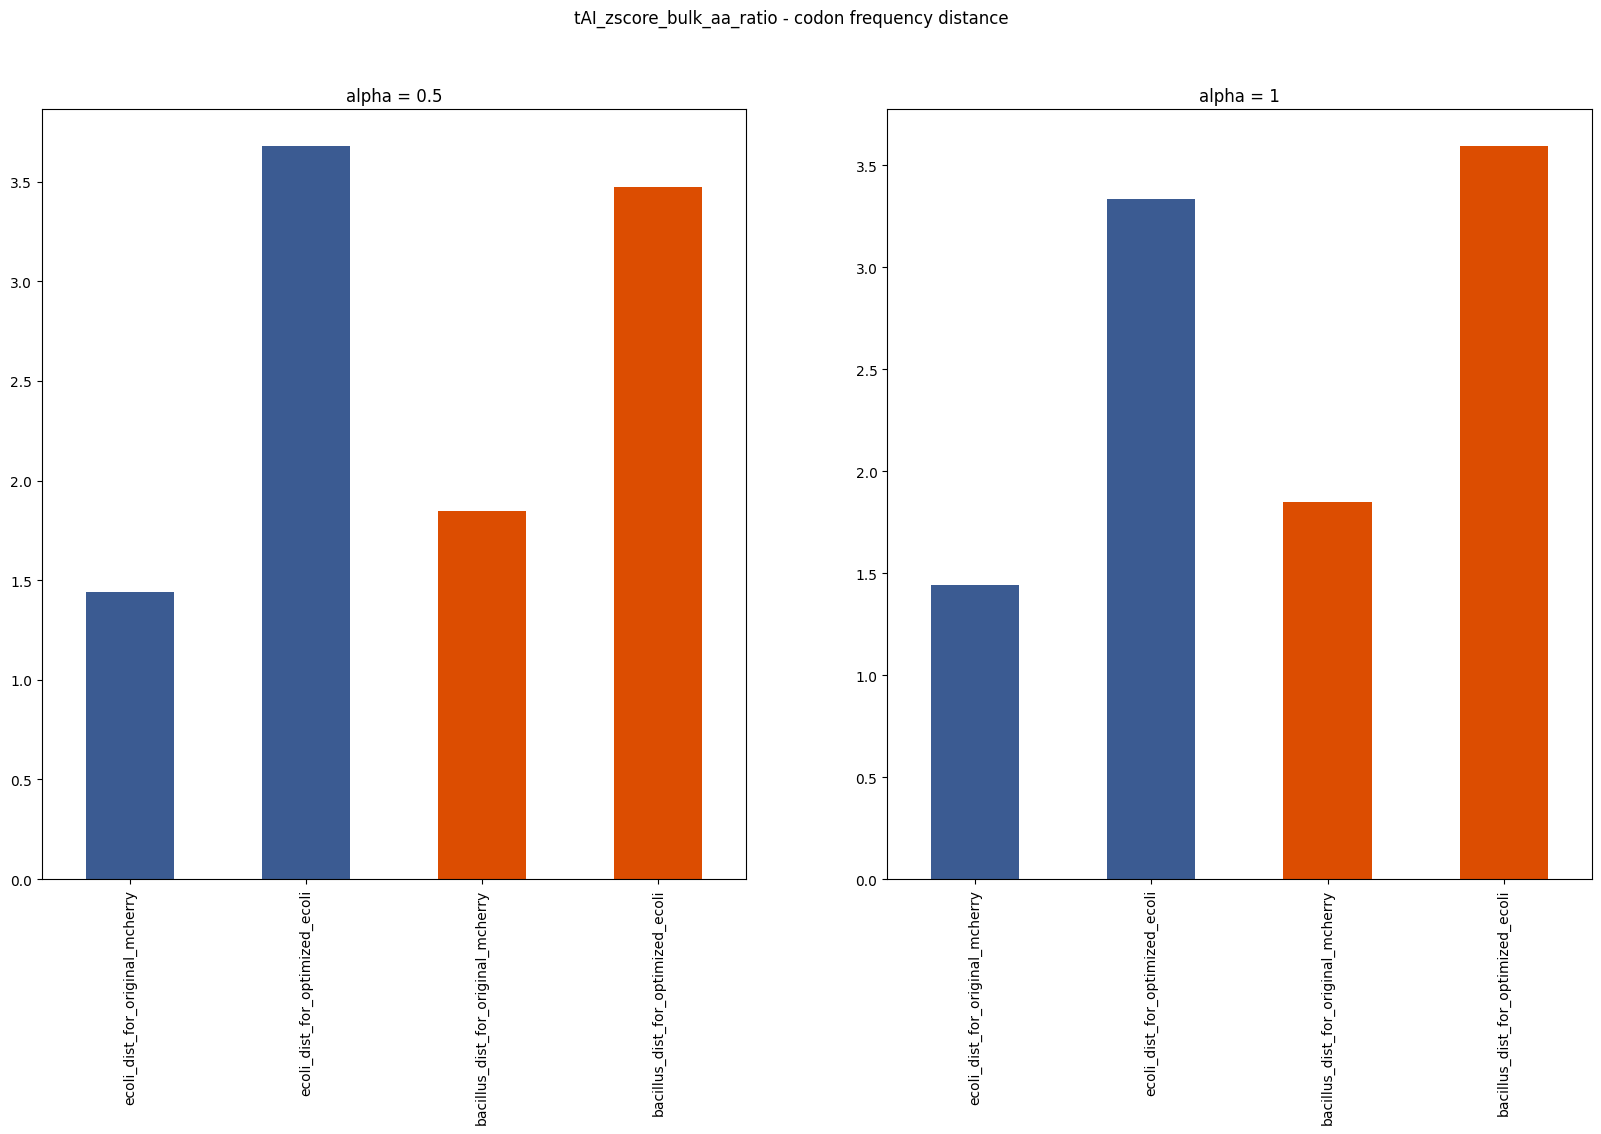

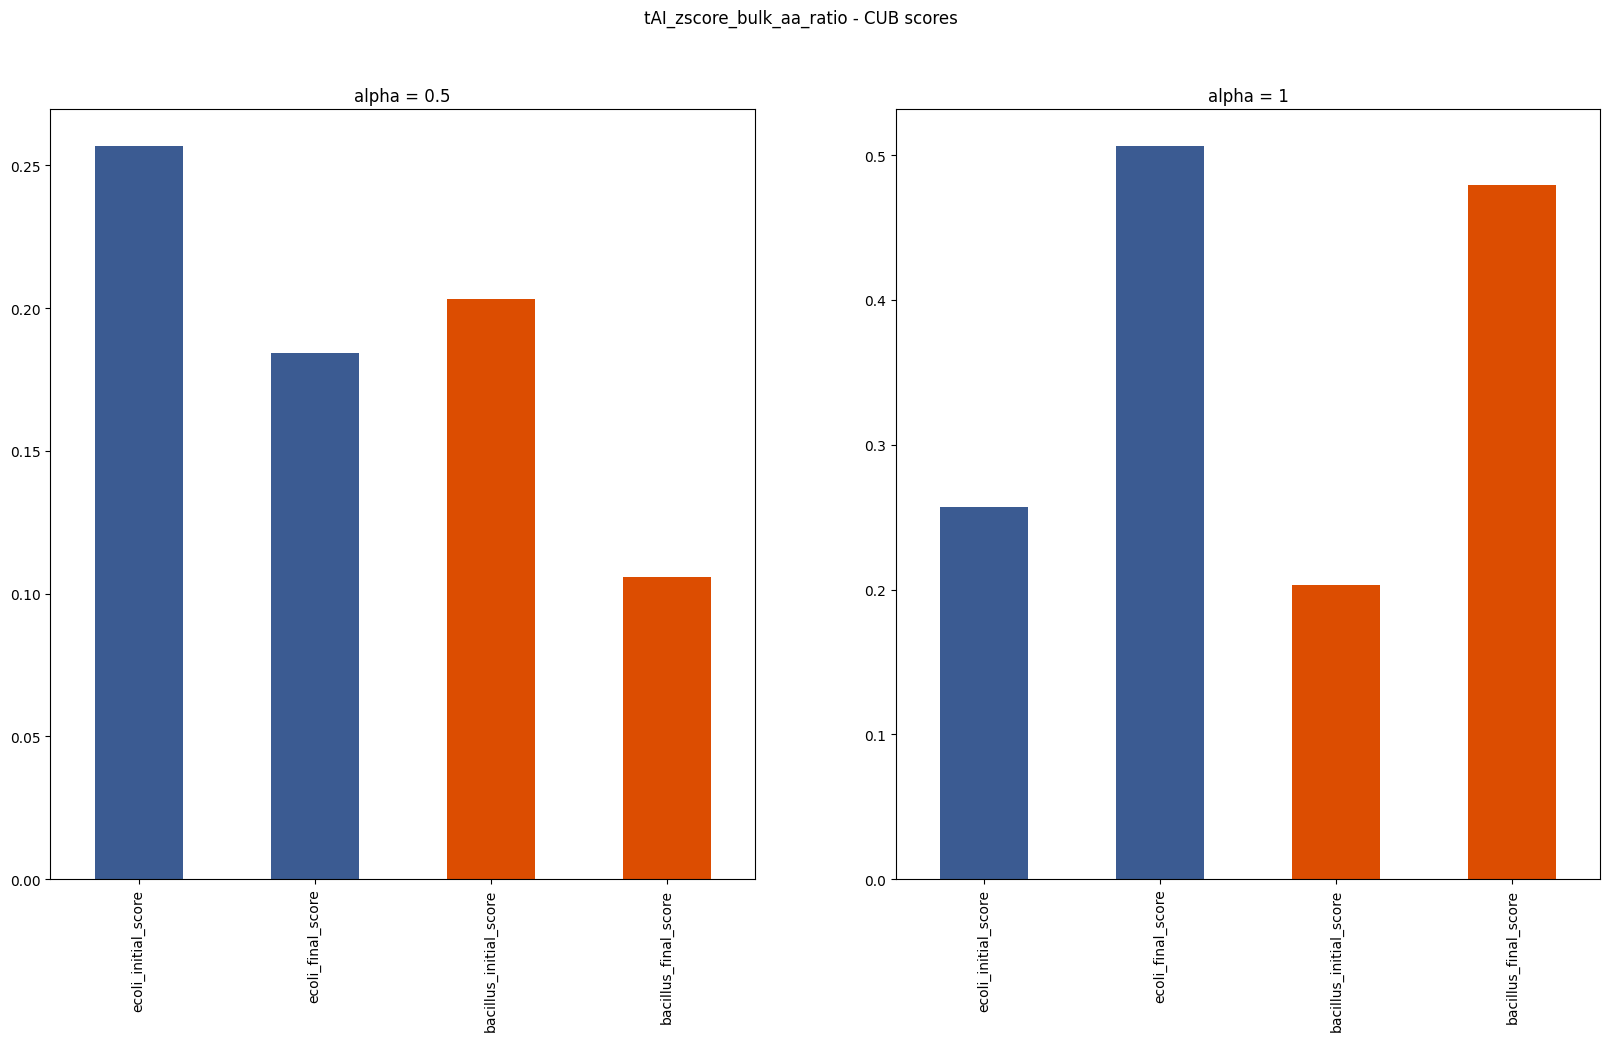

In [32]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
for q in range(cub_ecoli_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    fig.suptitle(cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0.5")
    cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 1")

## Optimizing for Bacillus

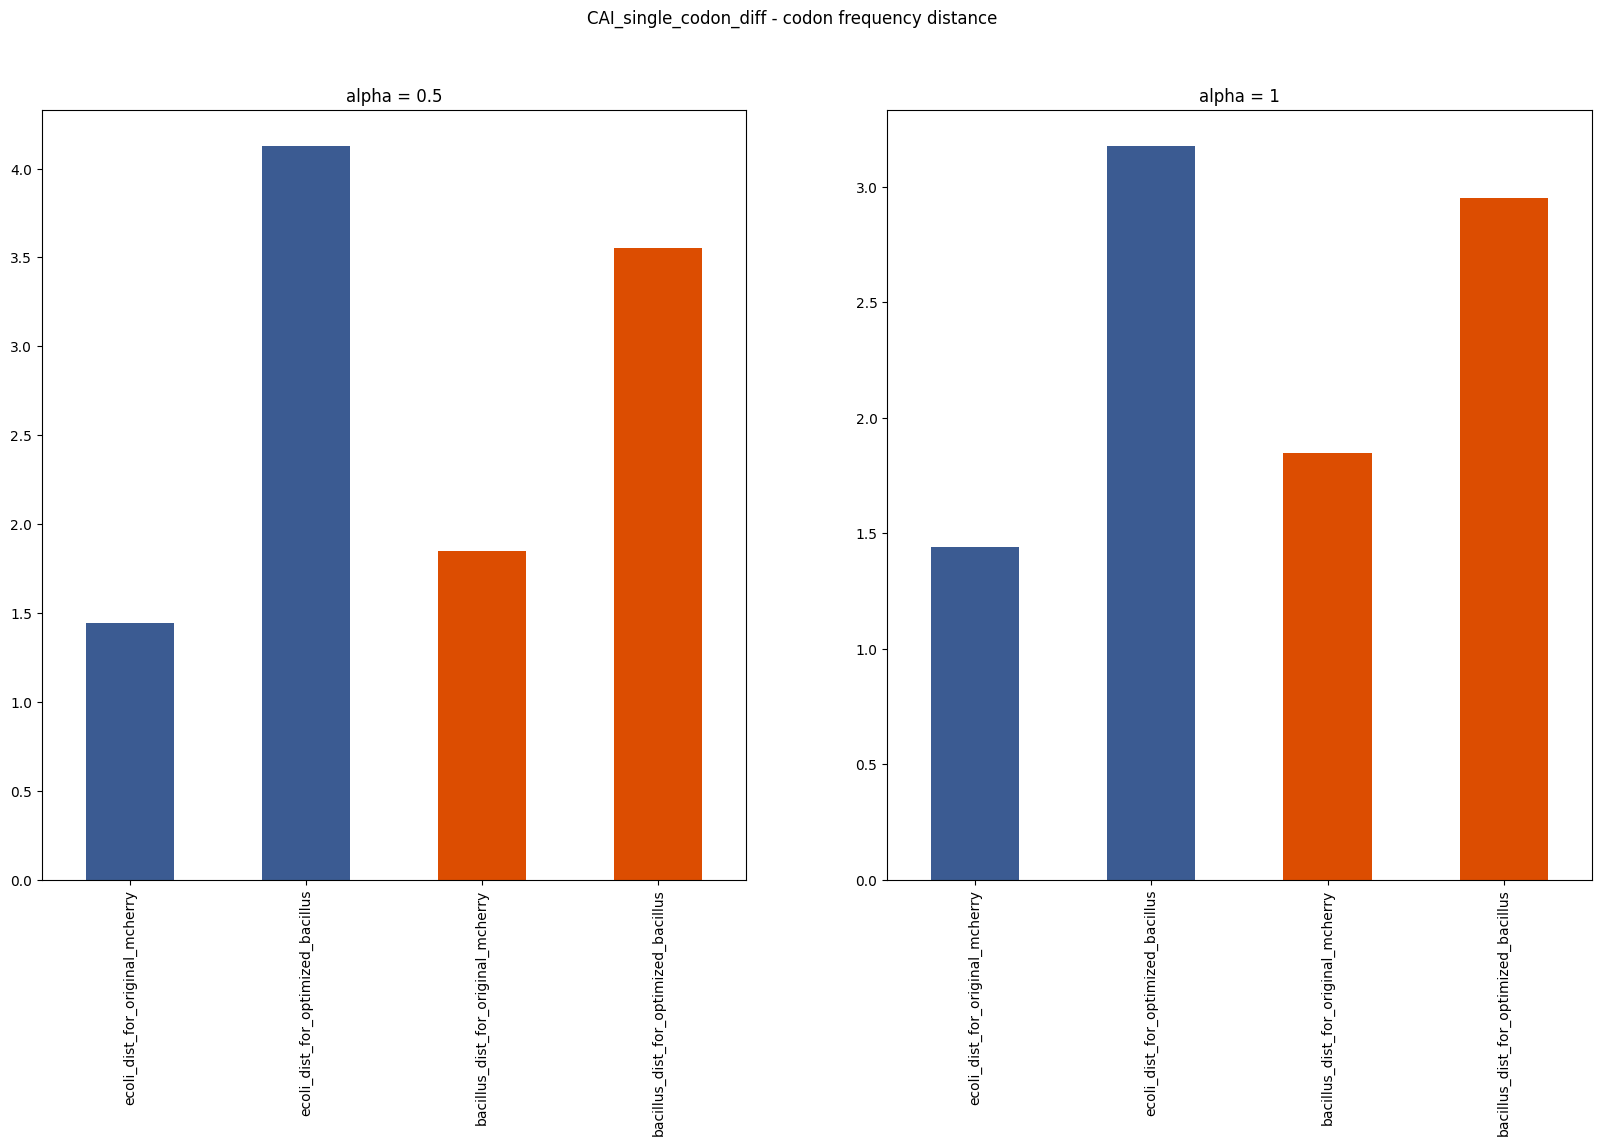

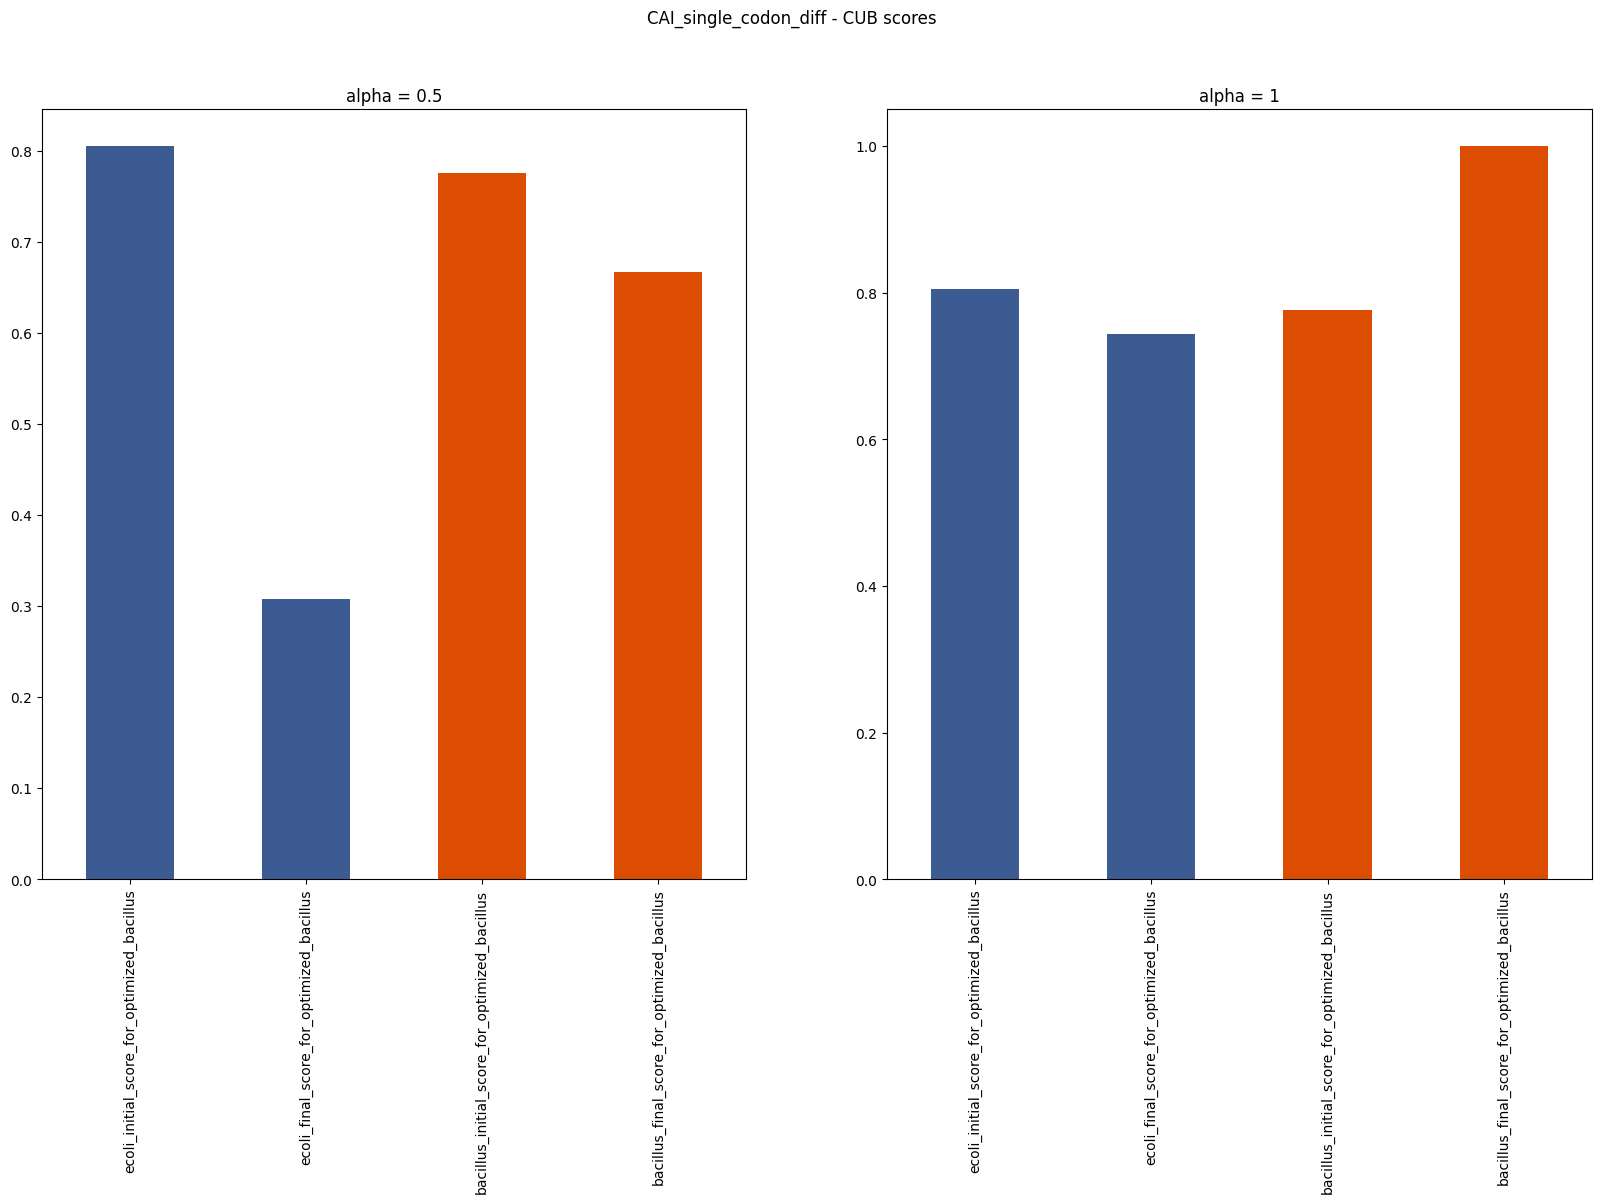

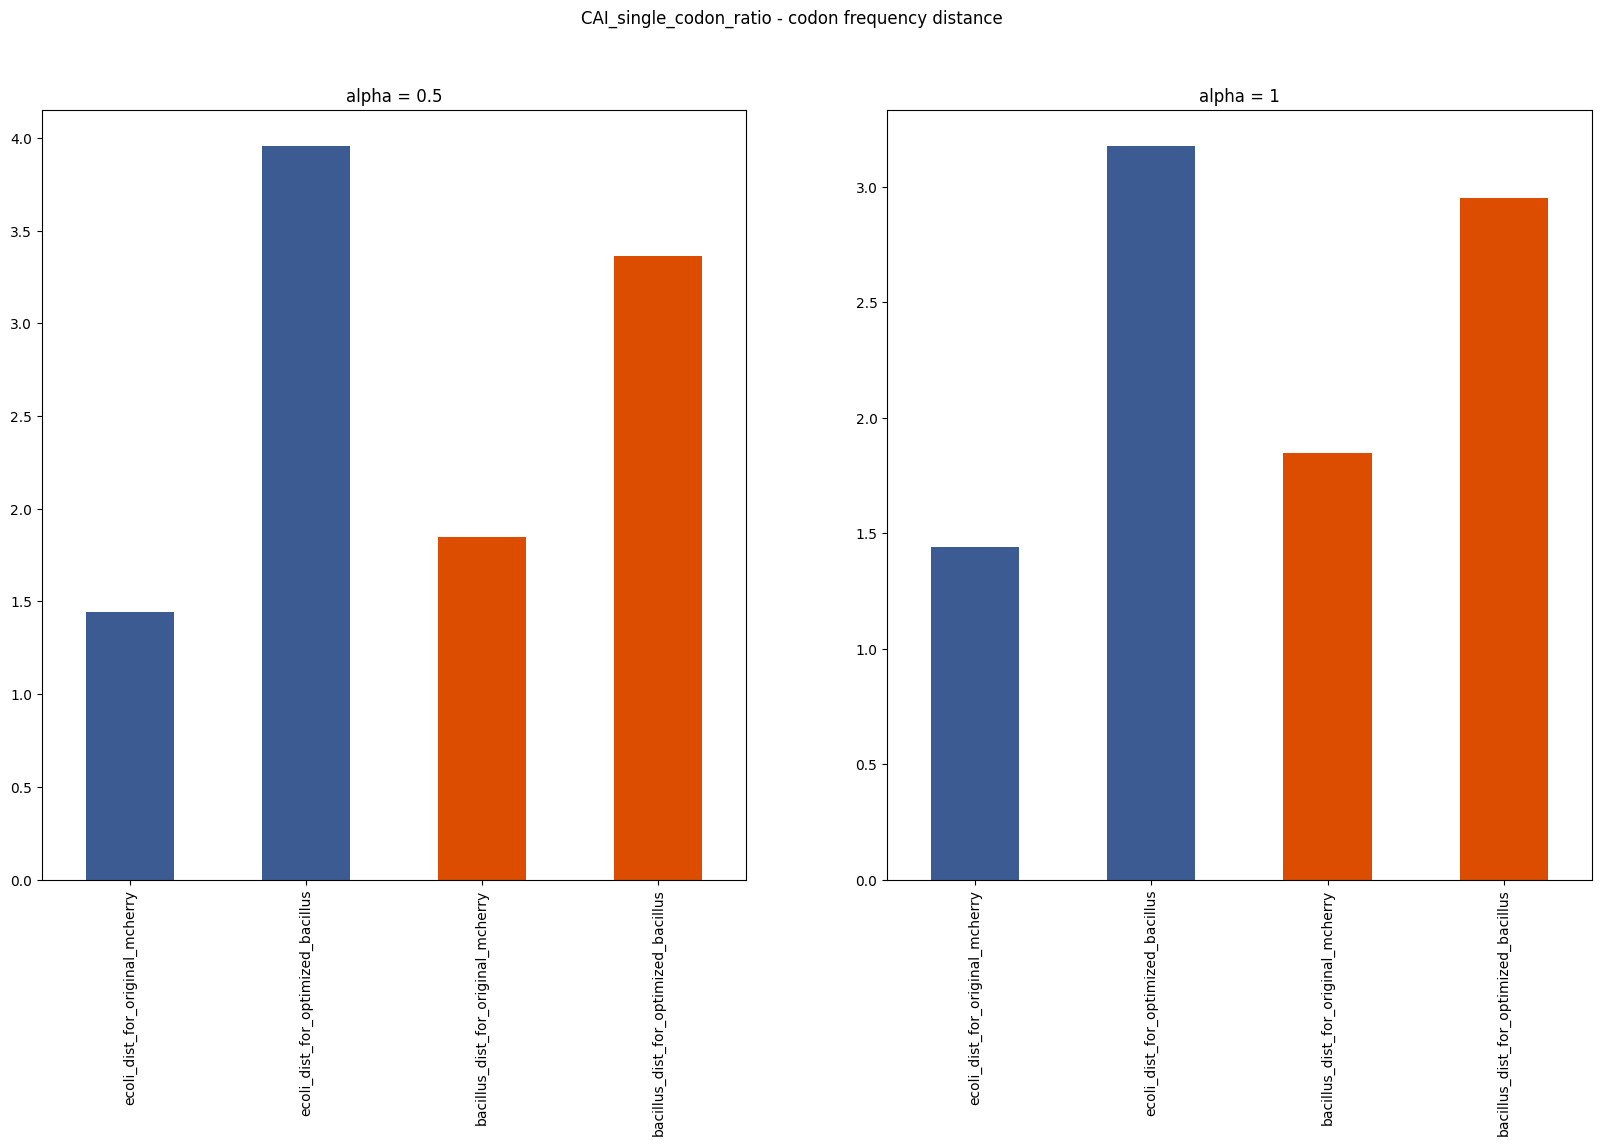

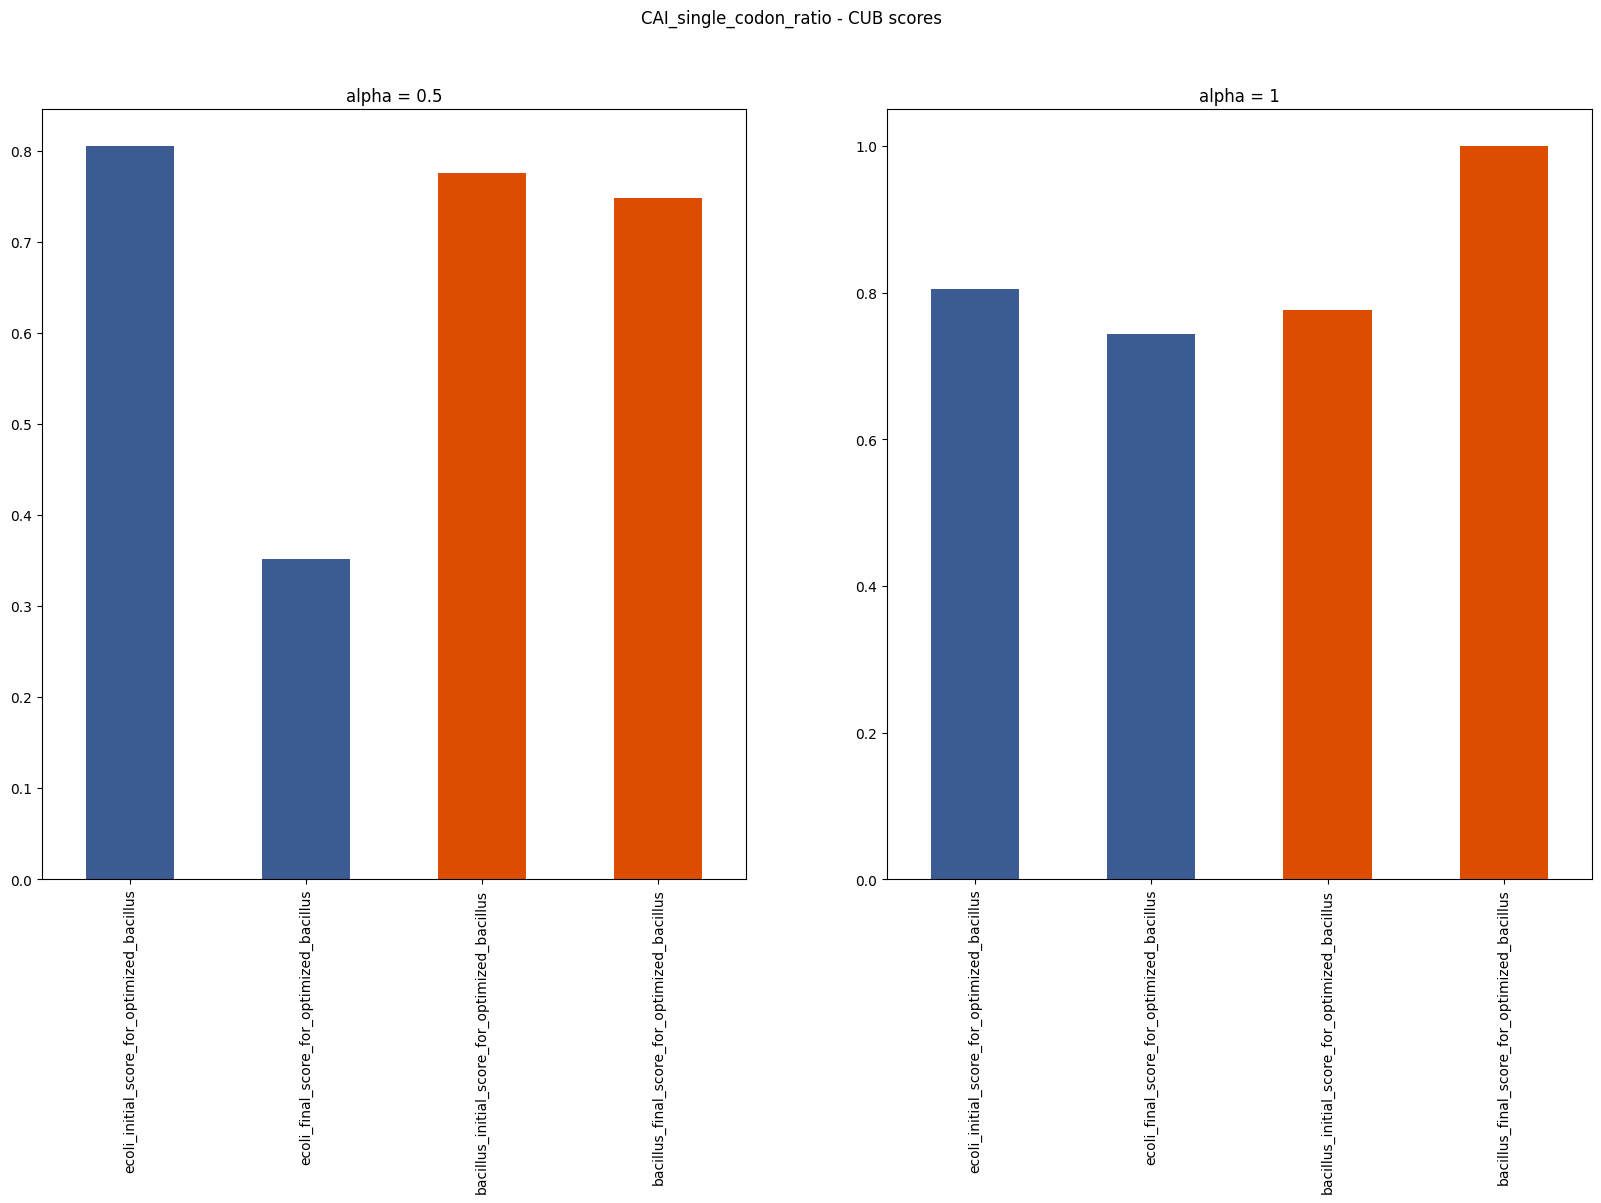

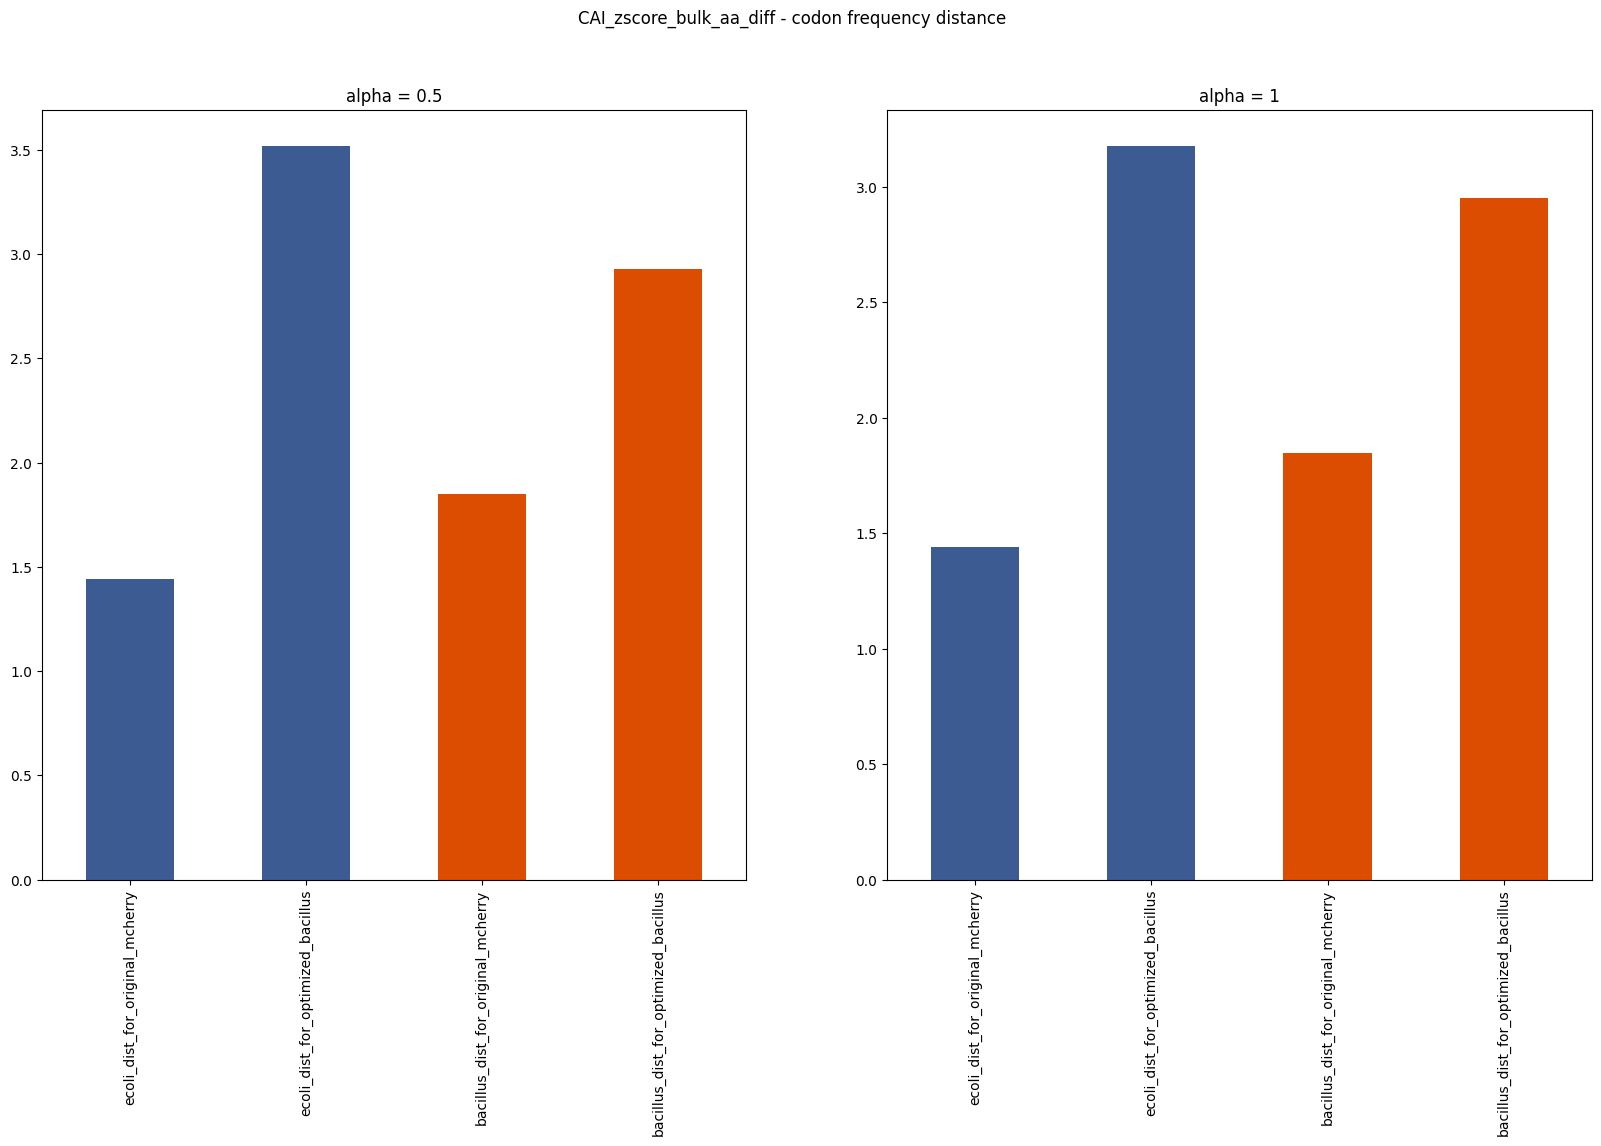

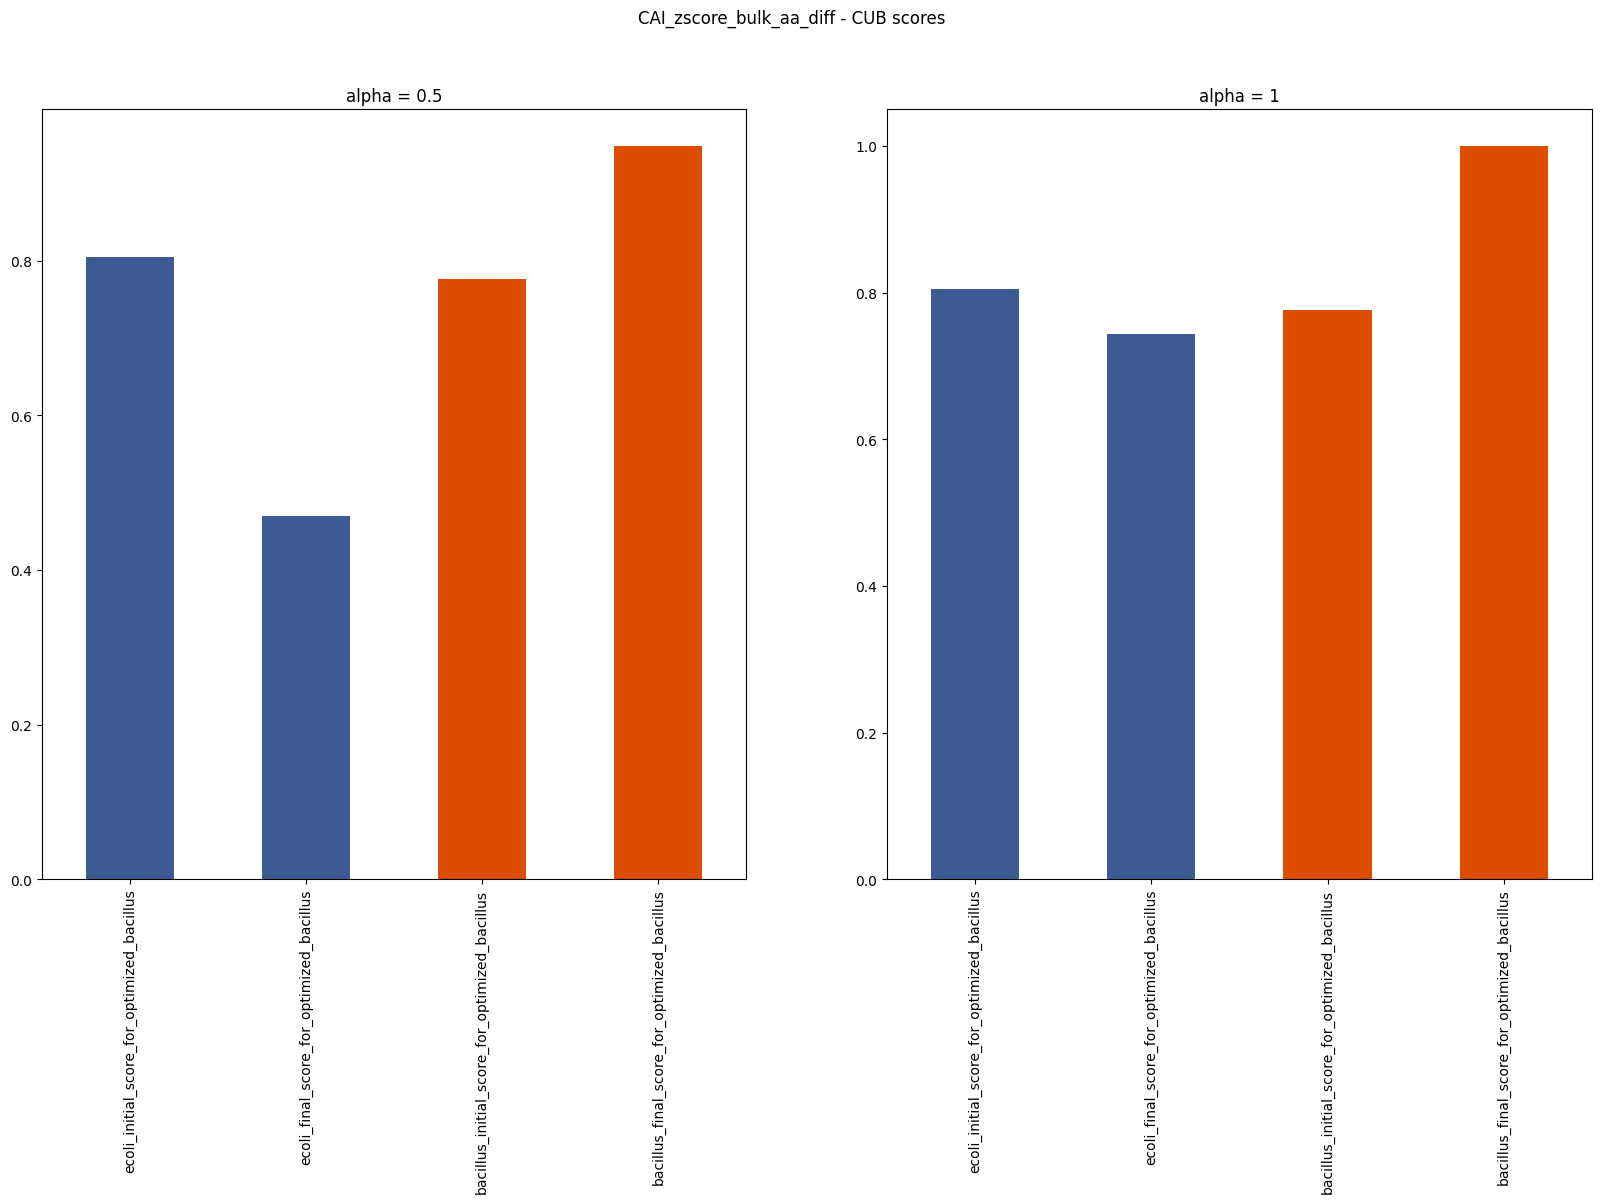

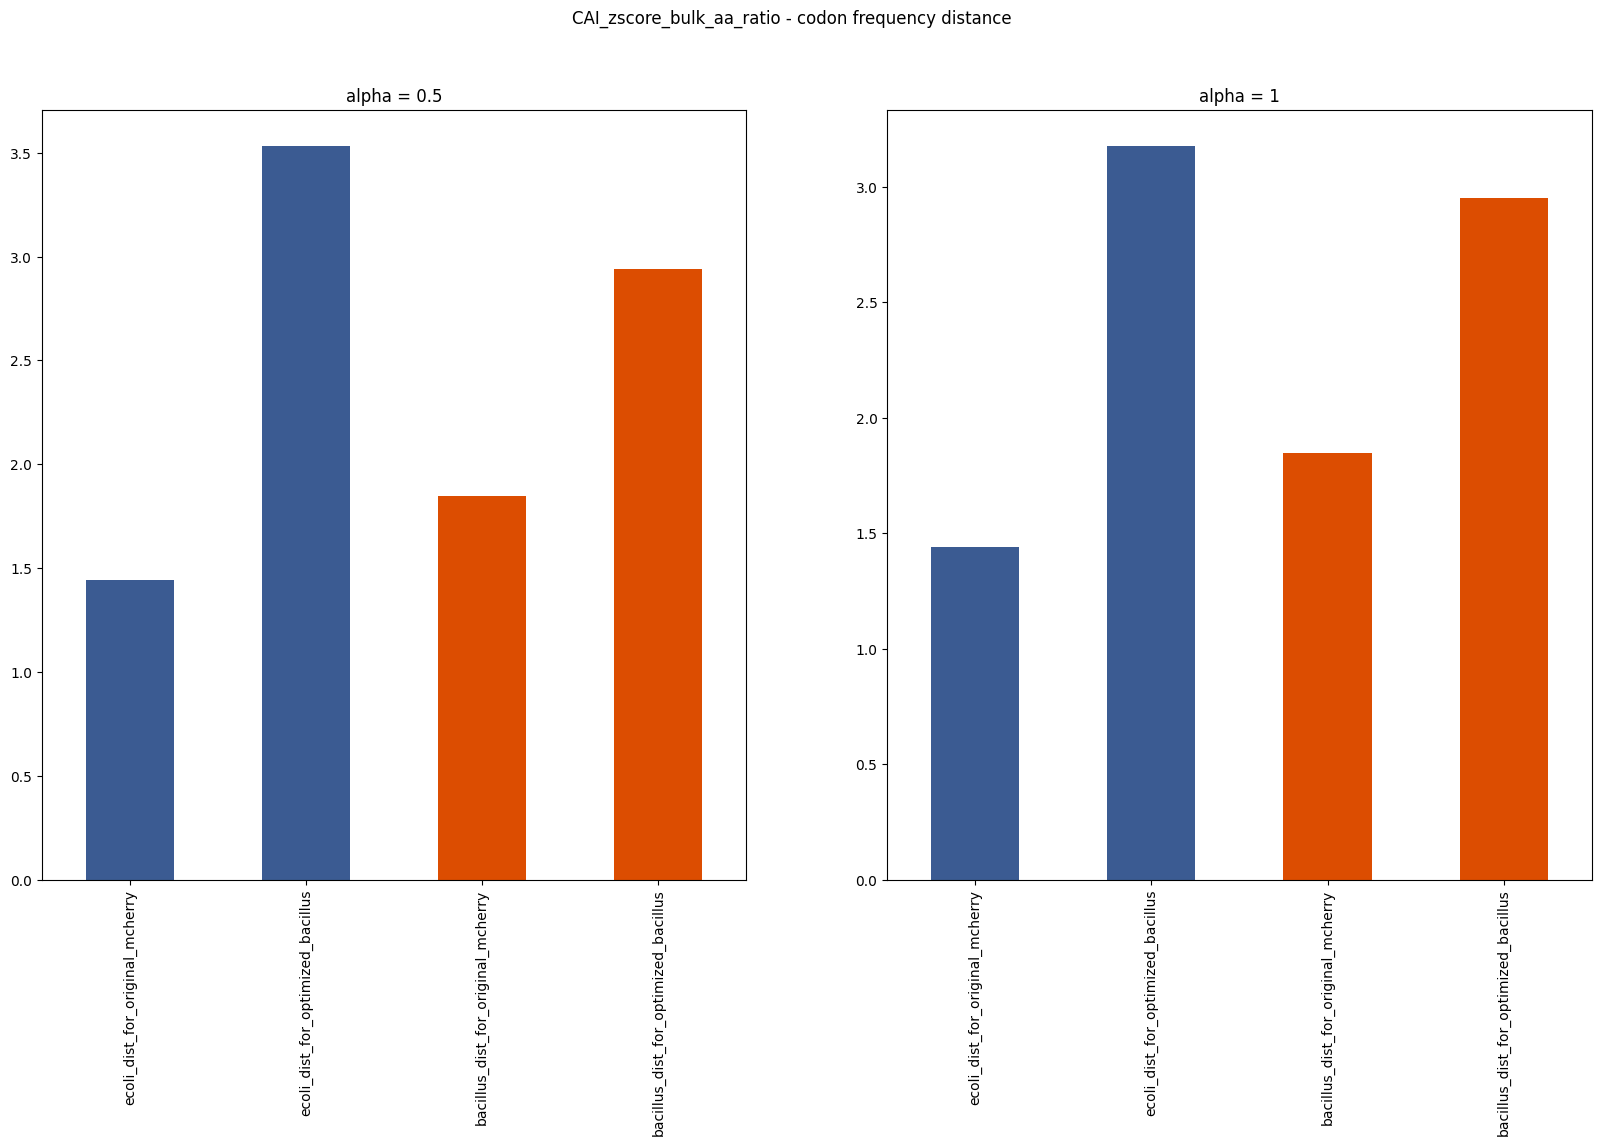

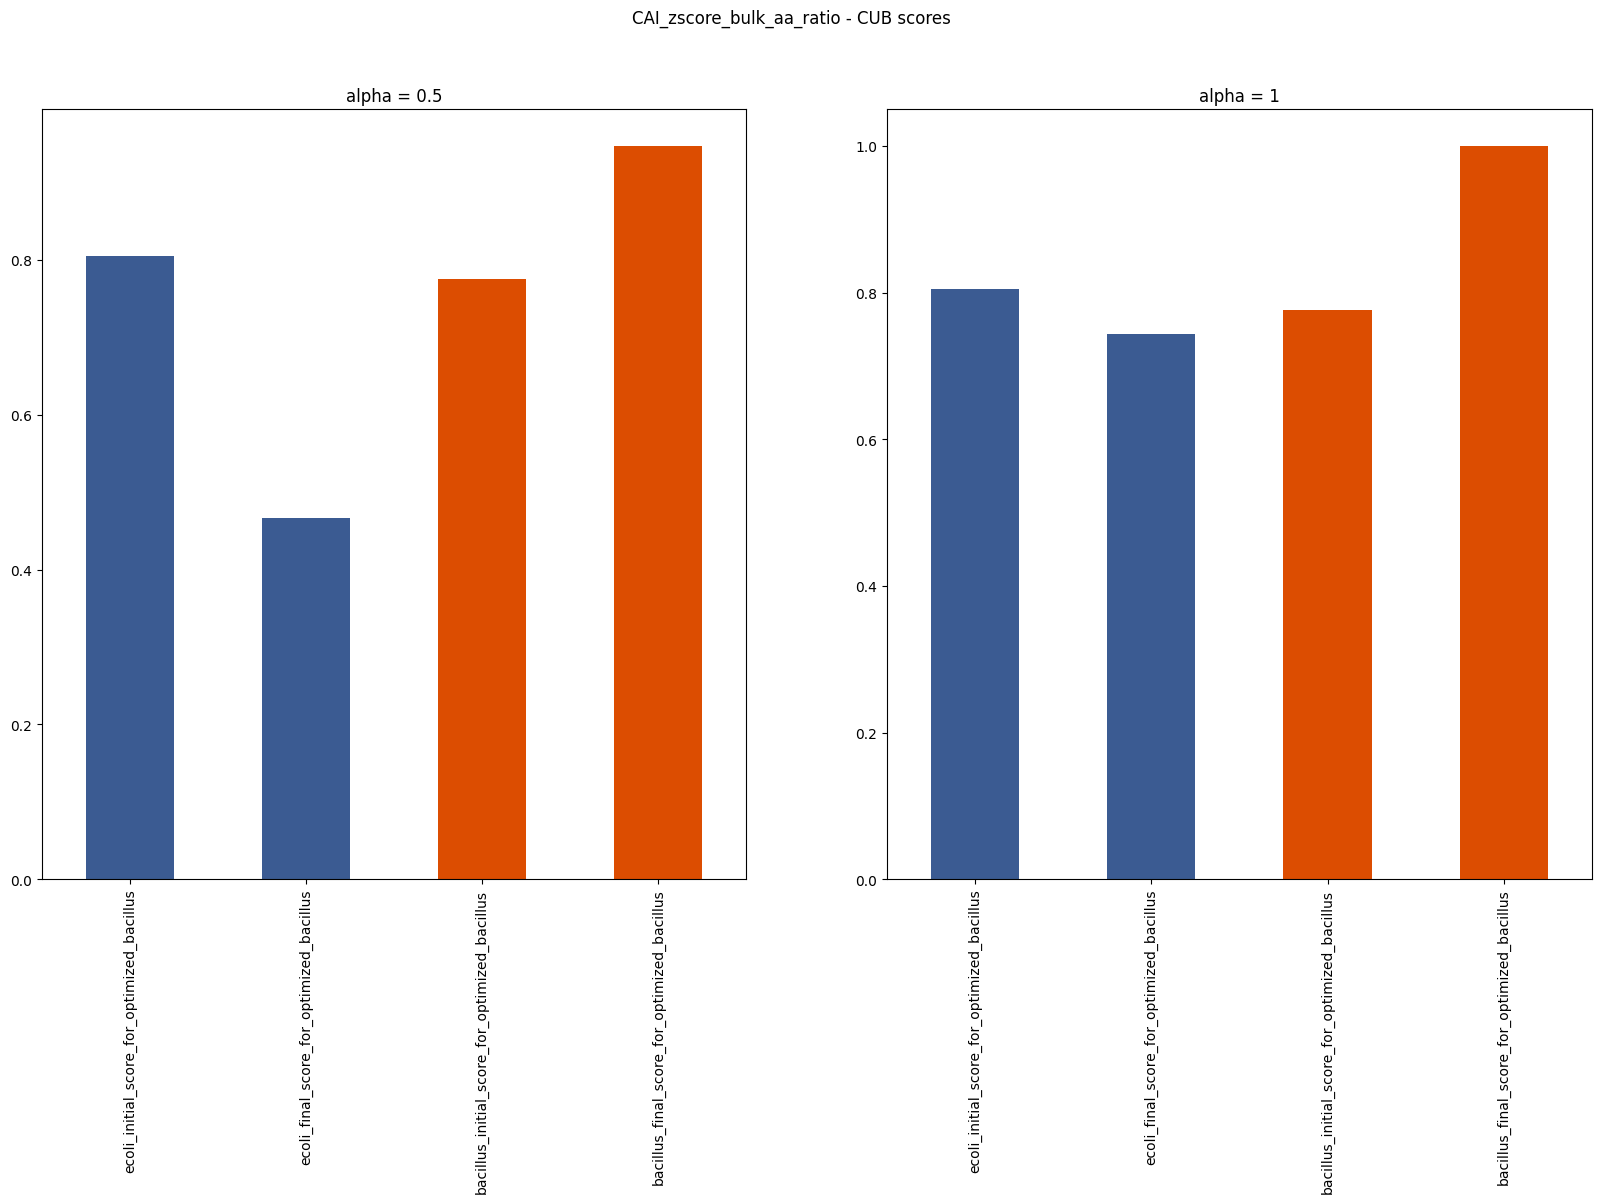

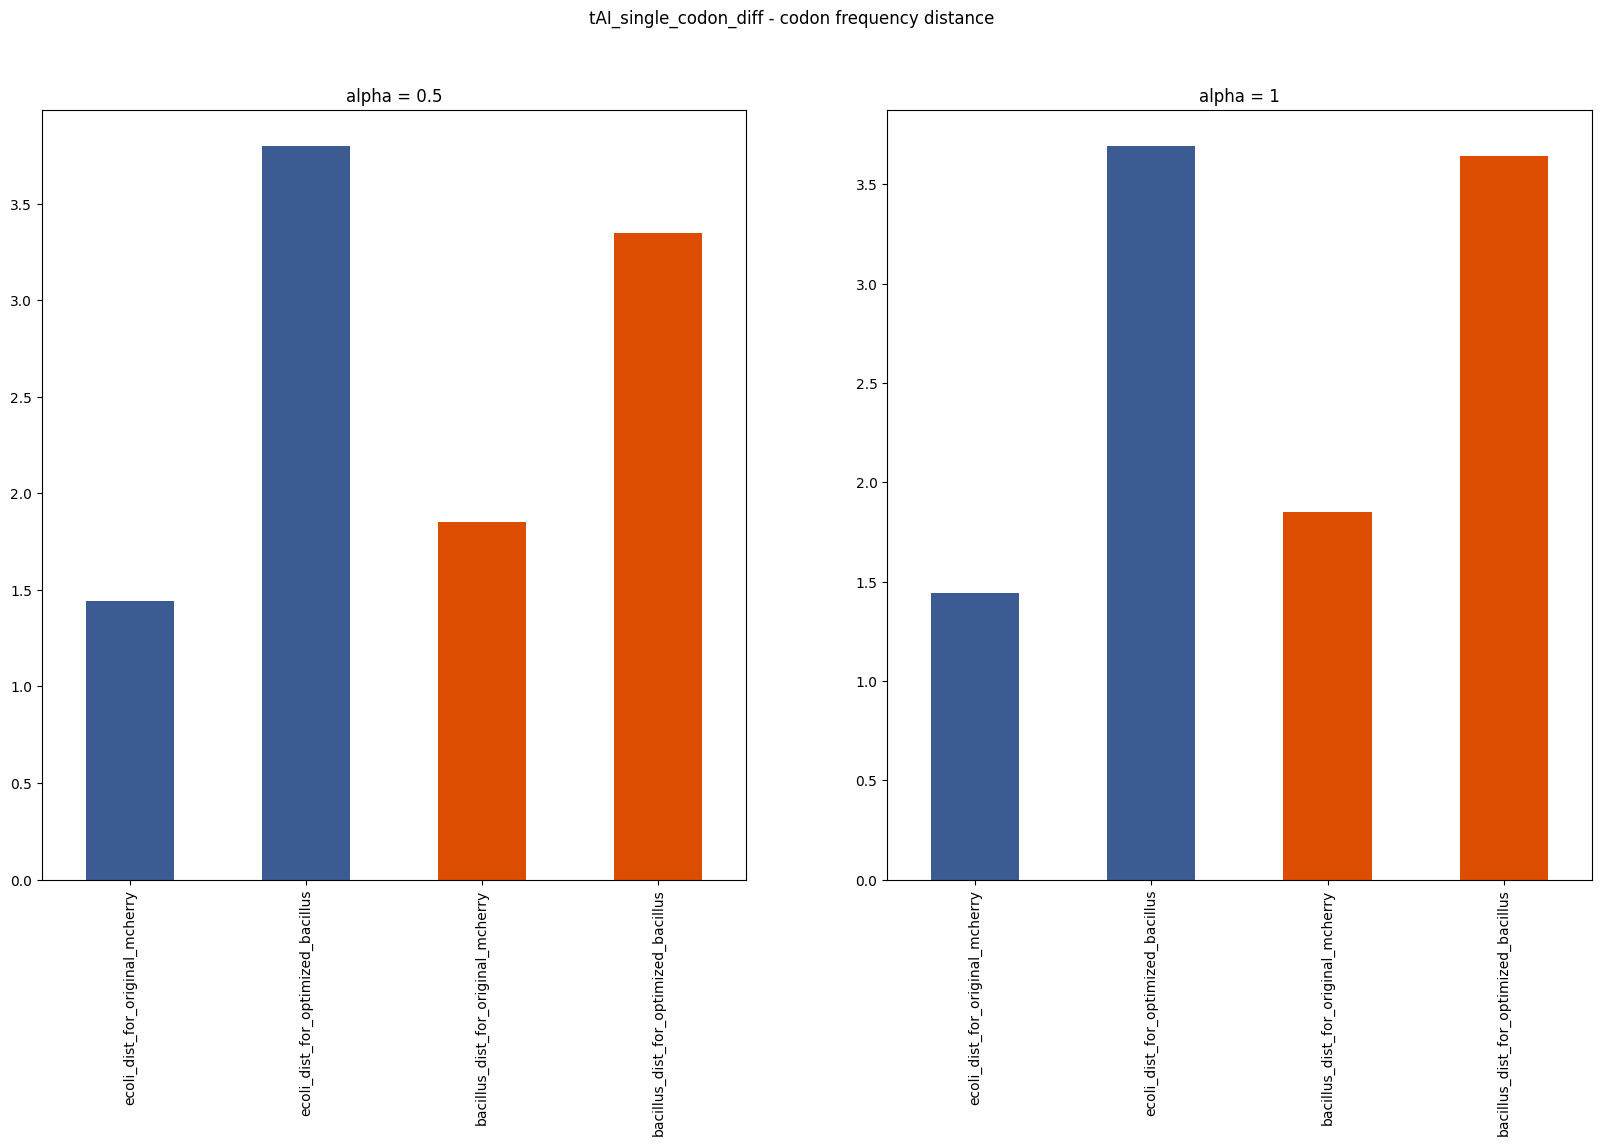

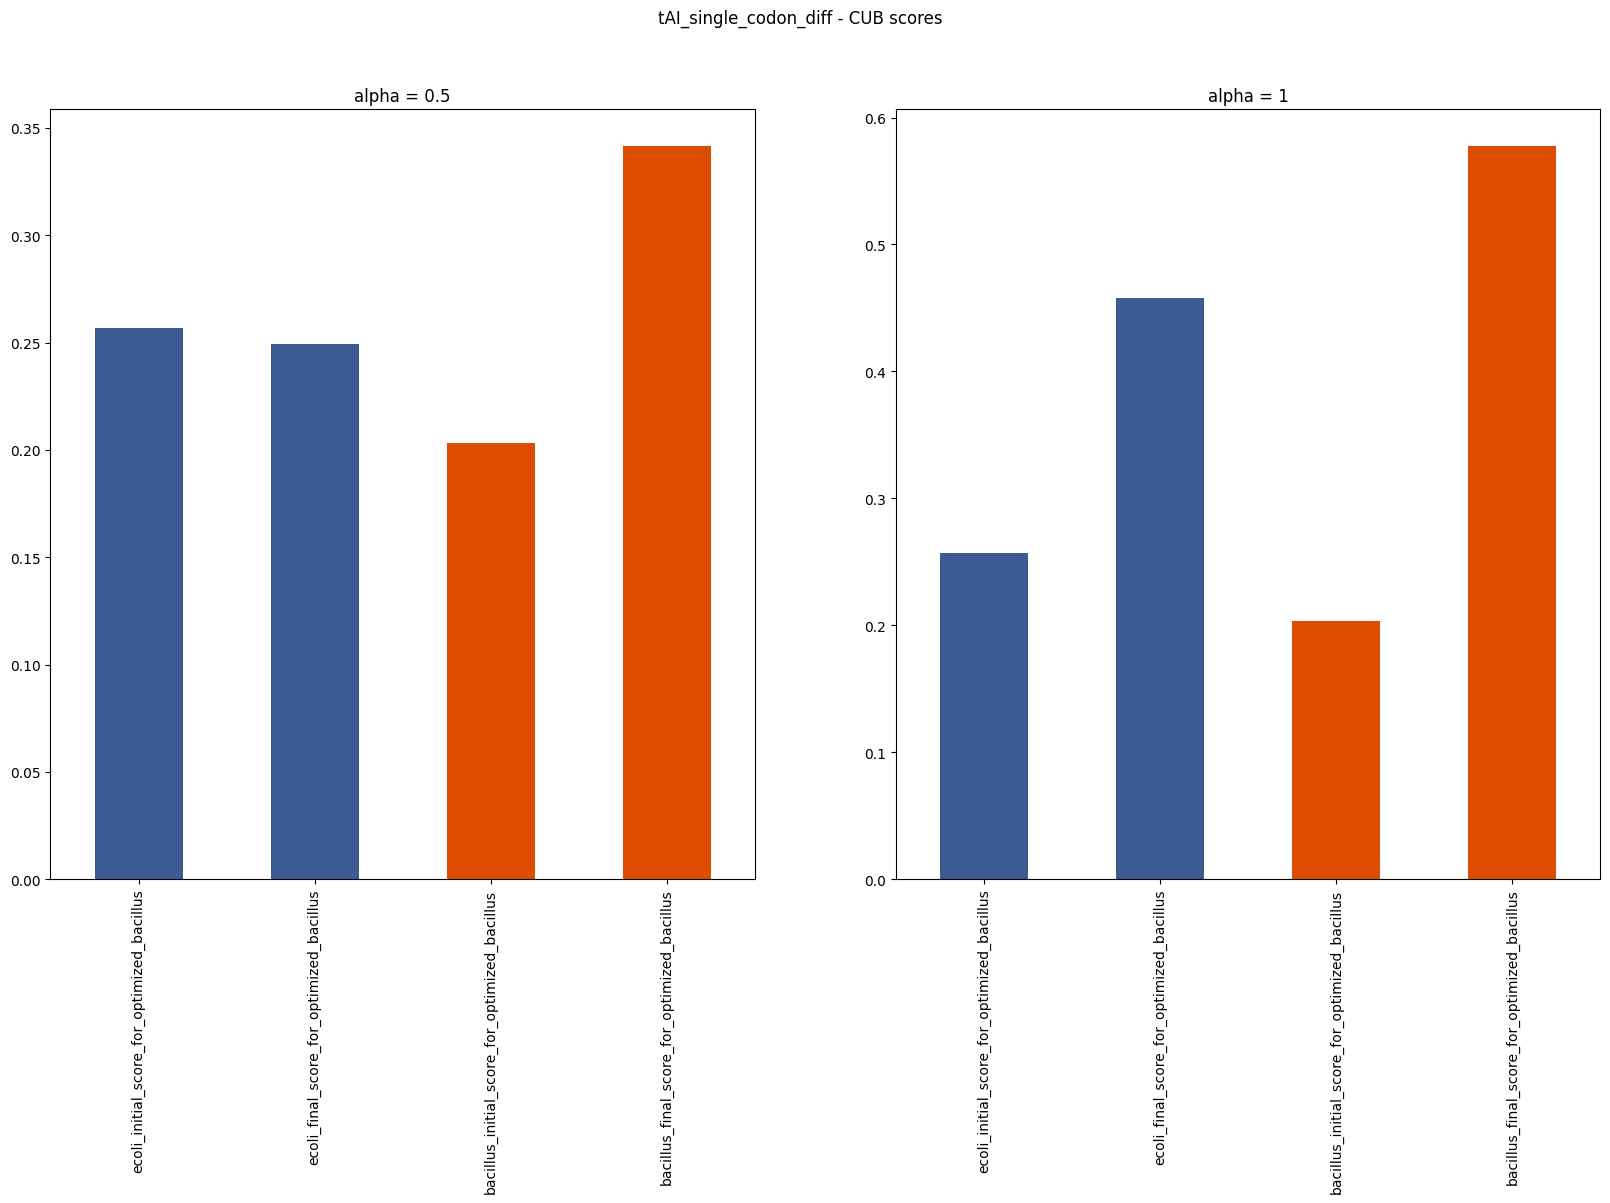

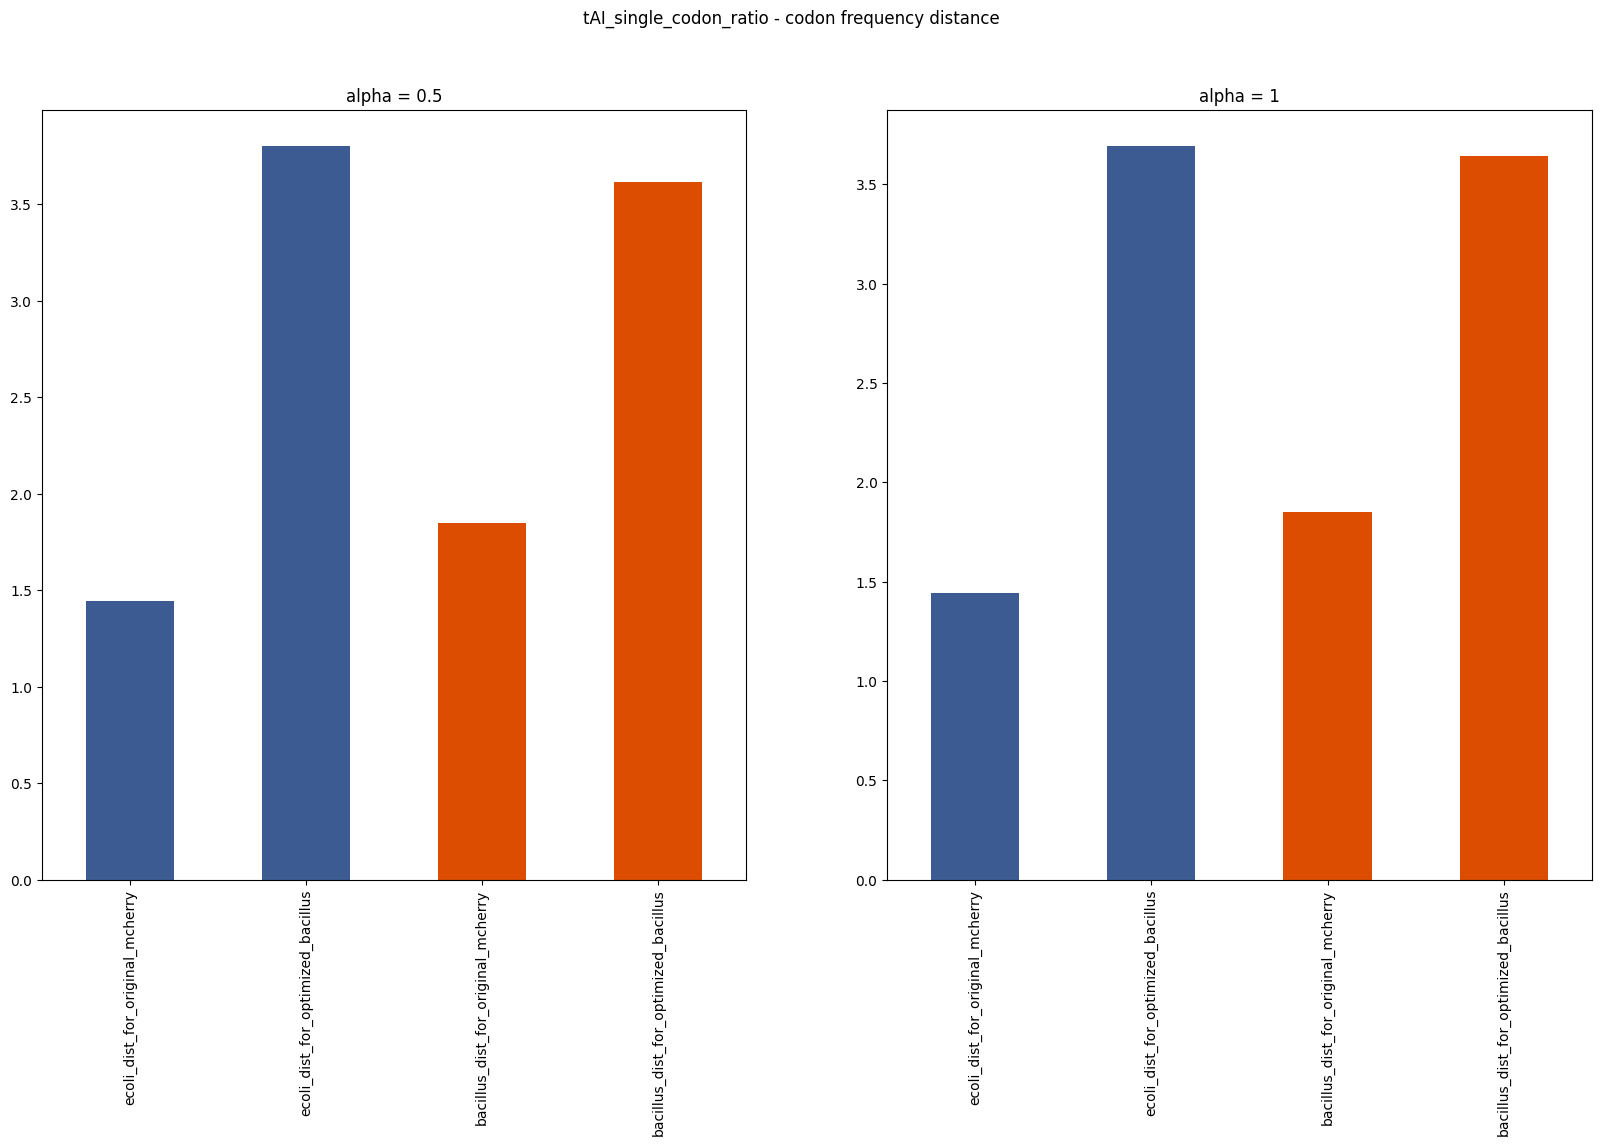

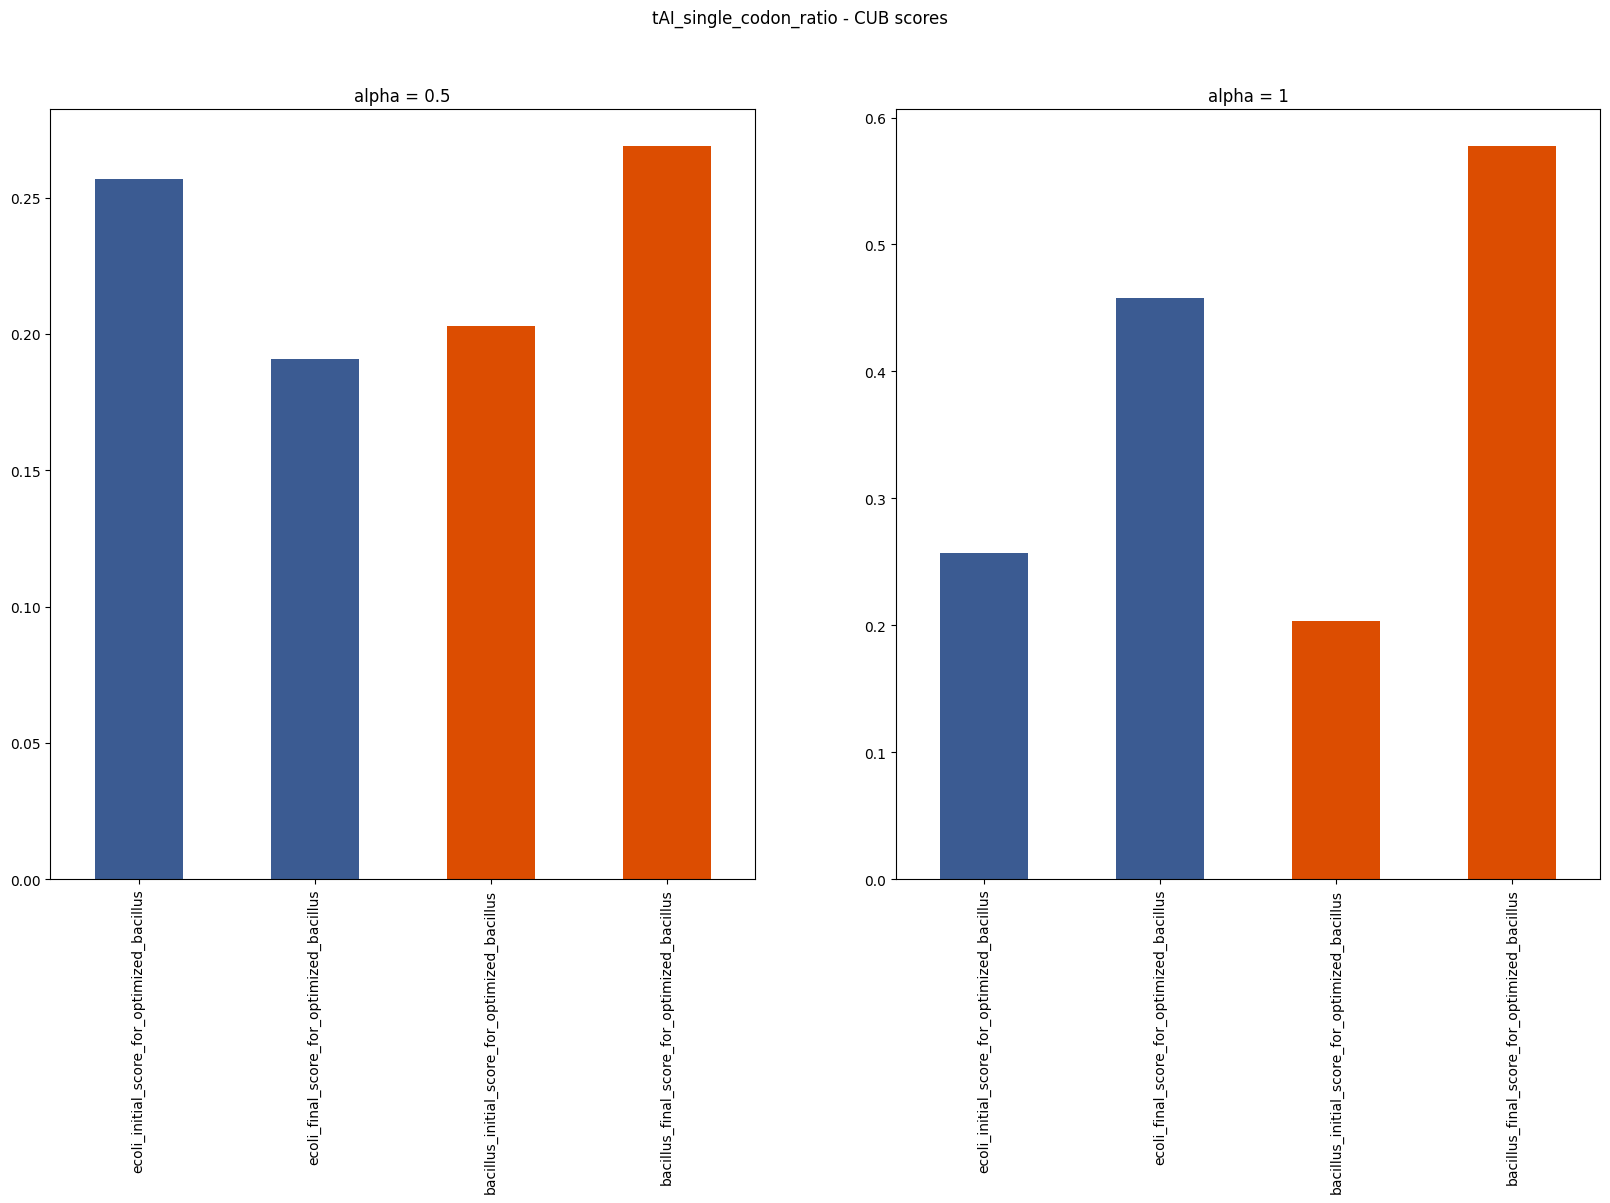

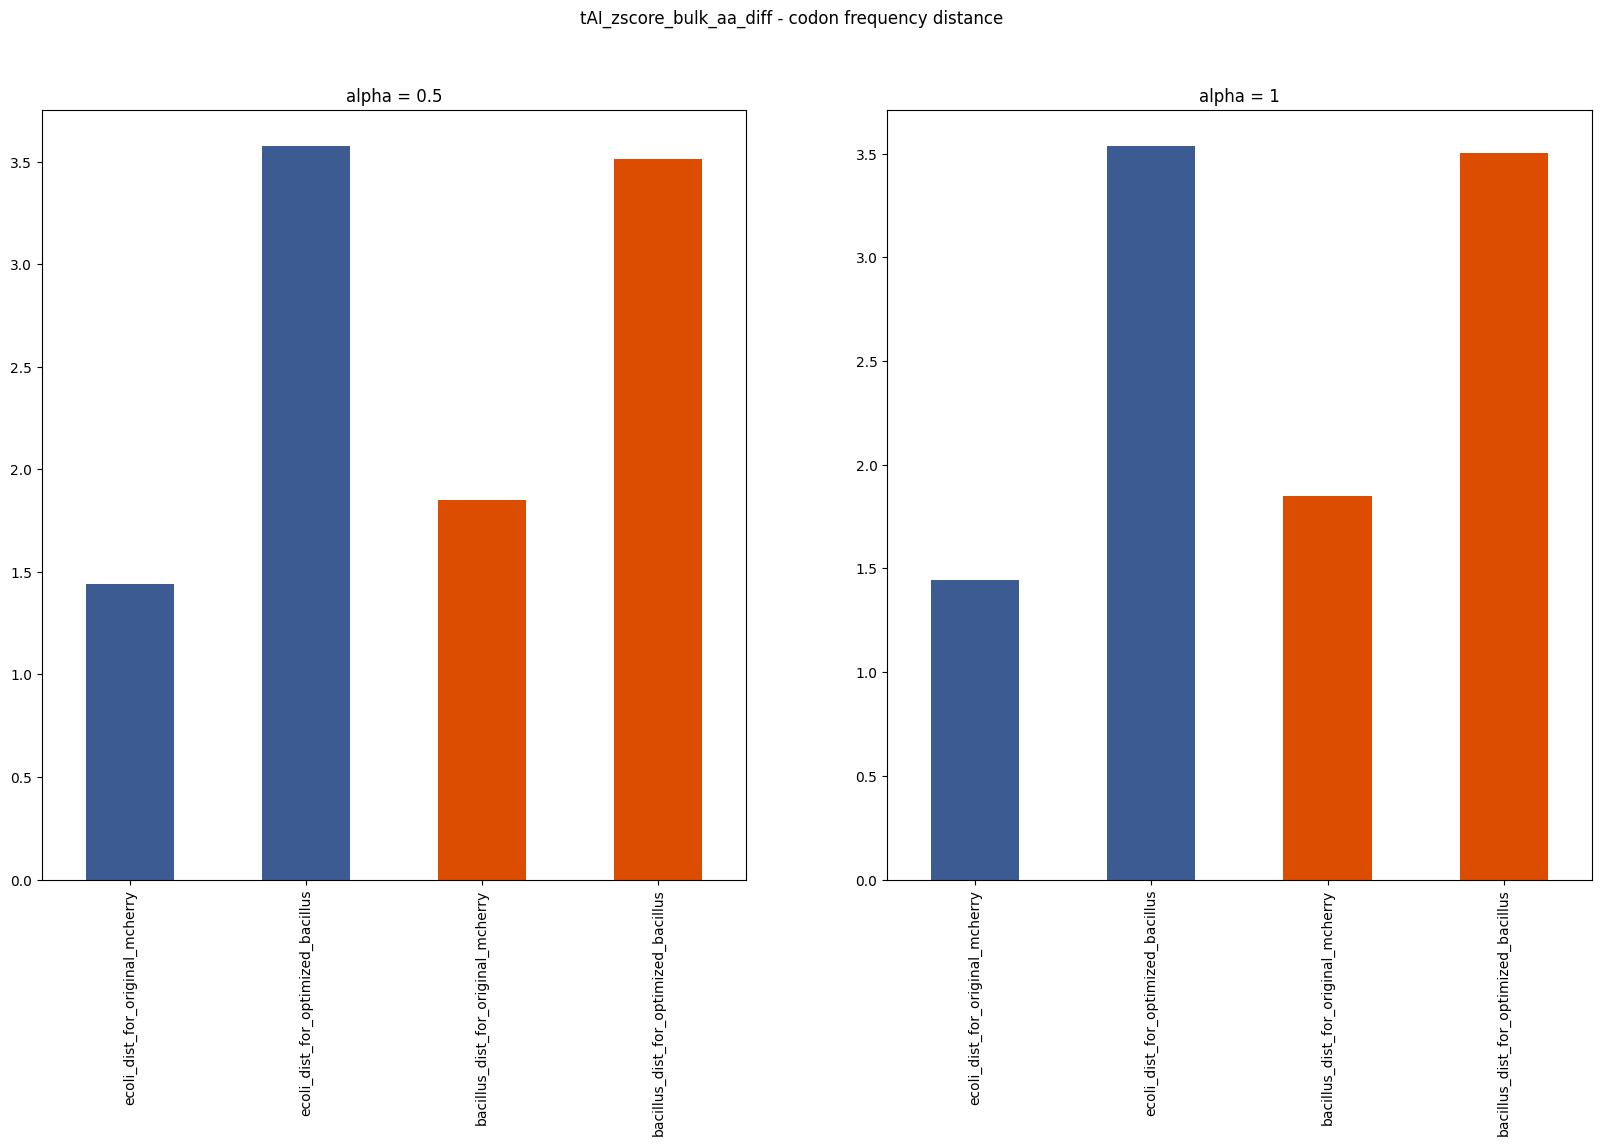

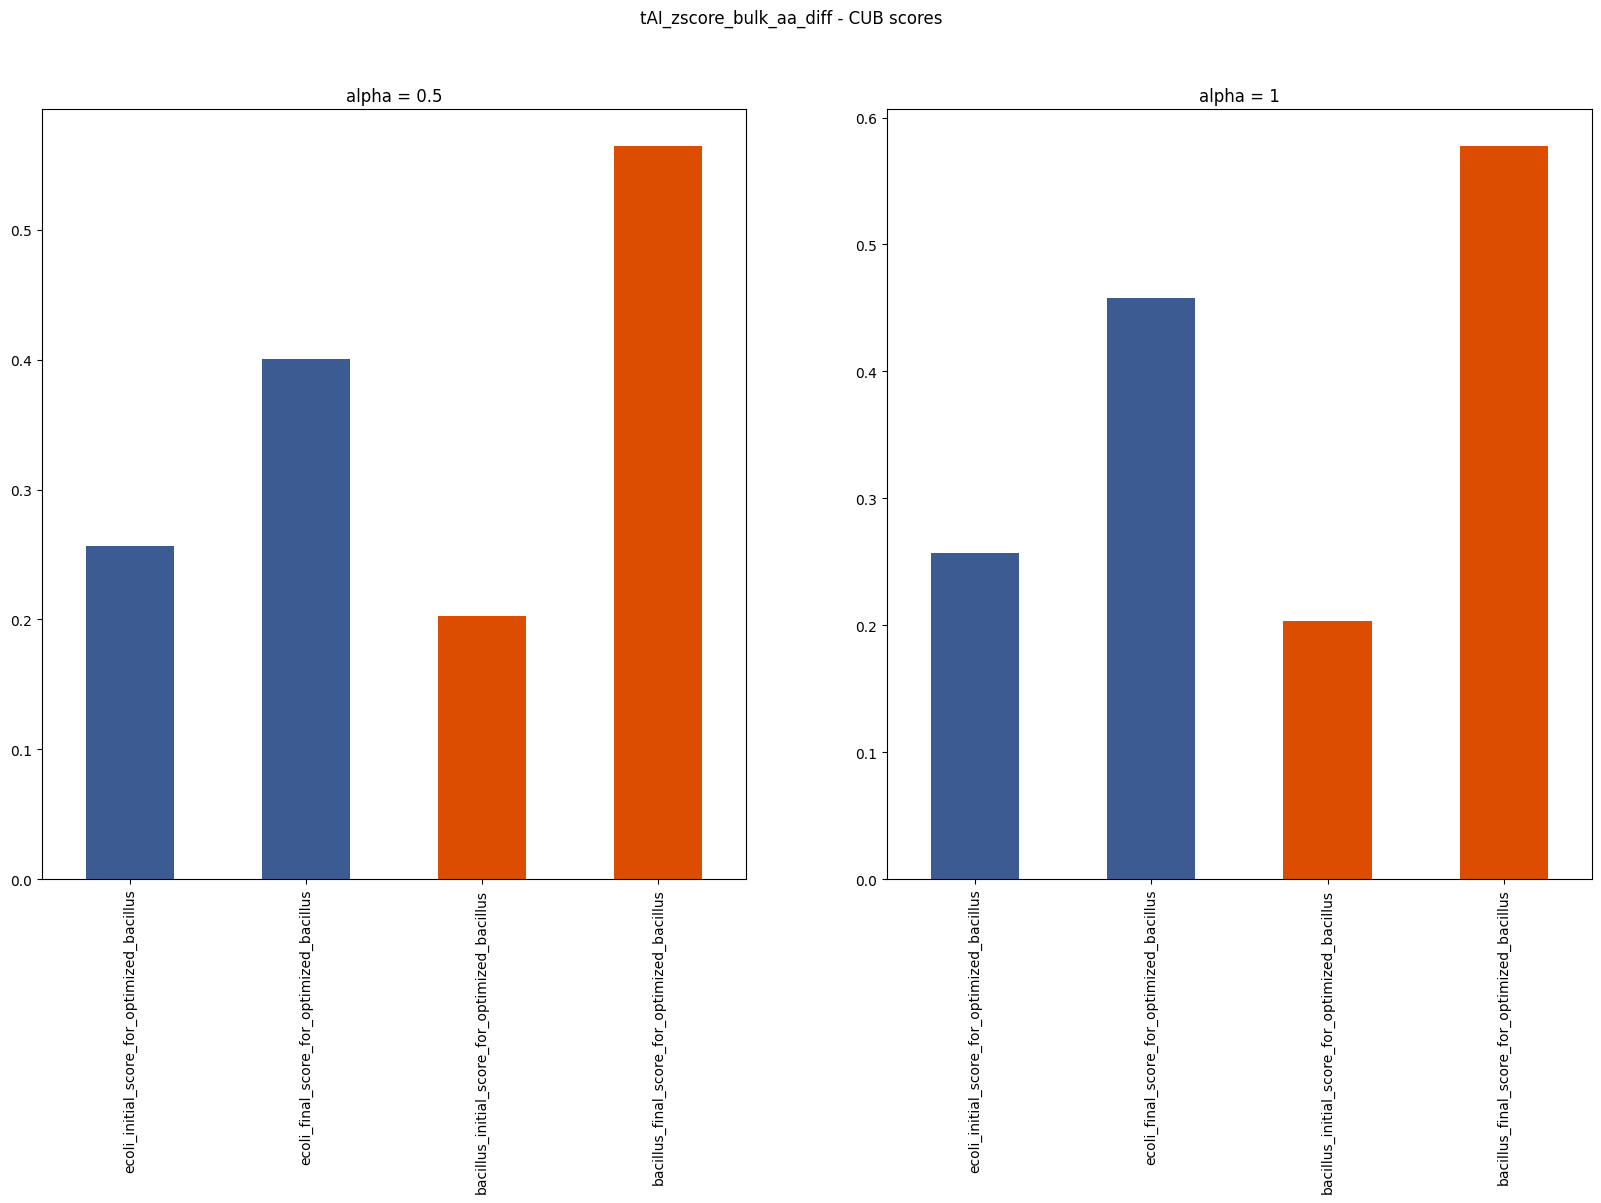

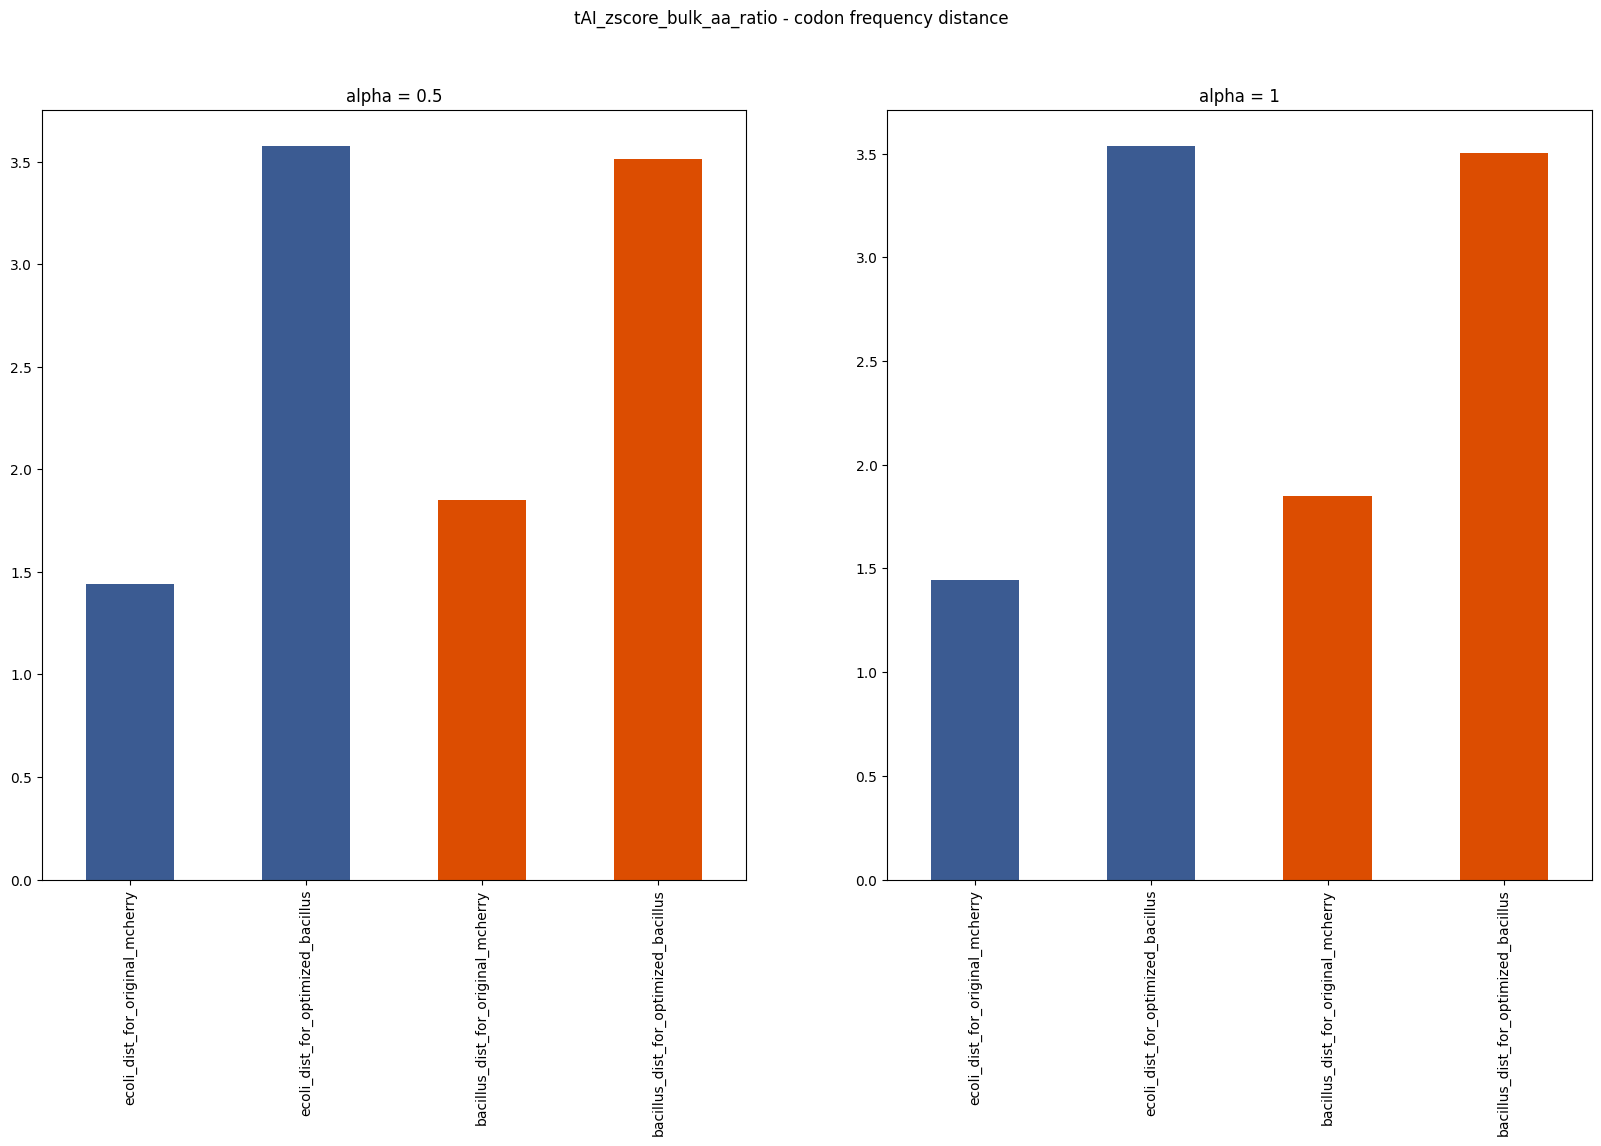

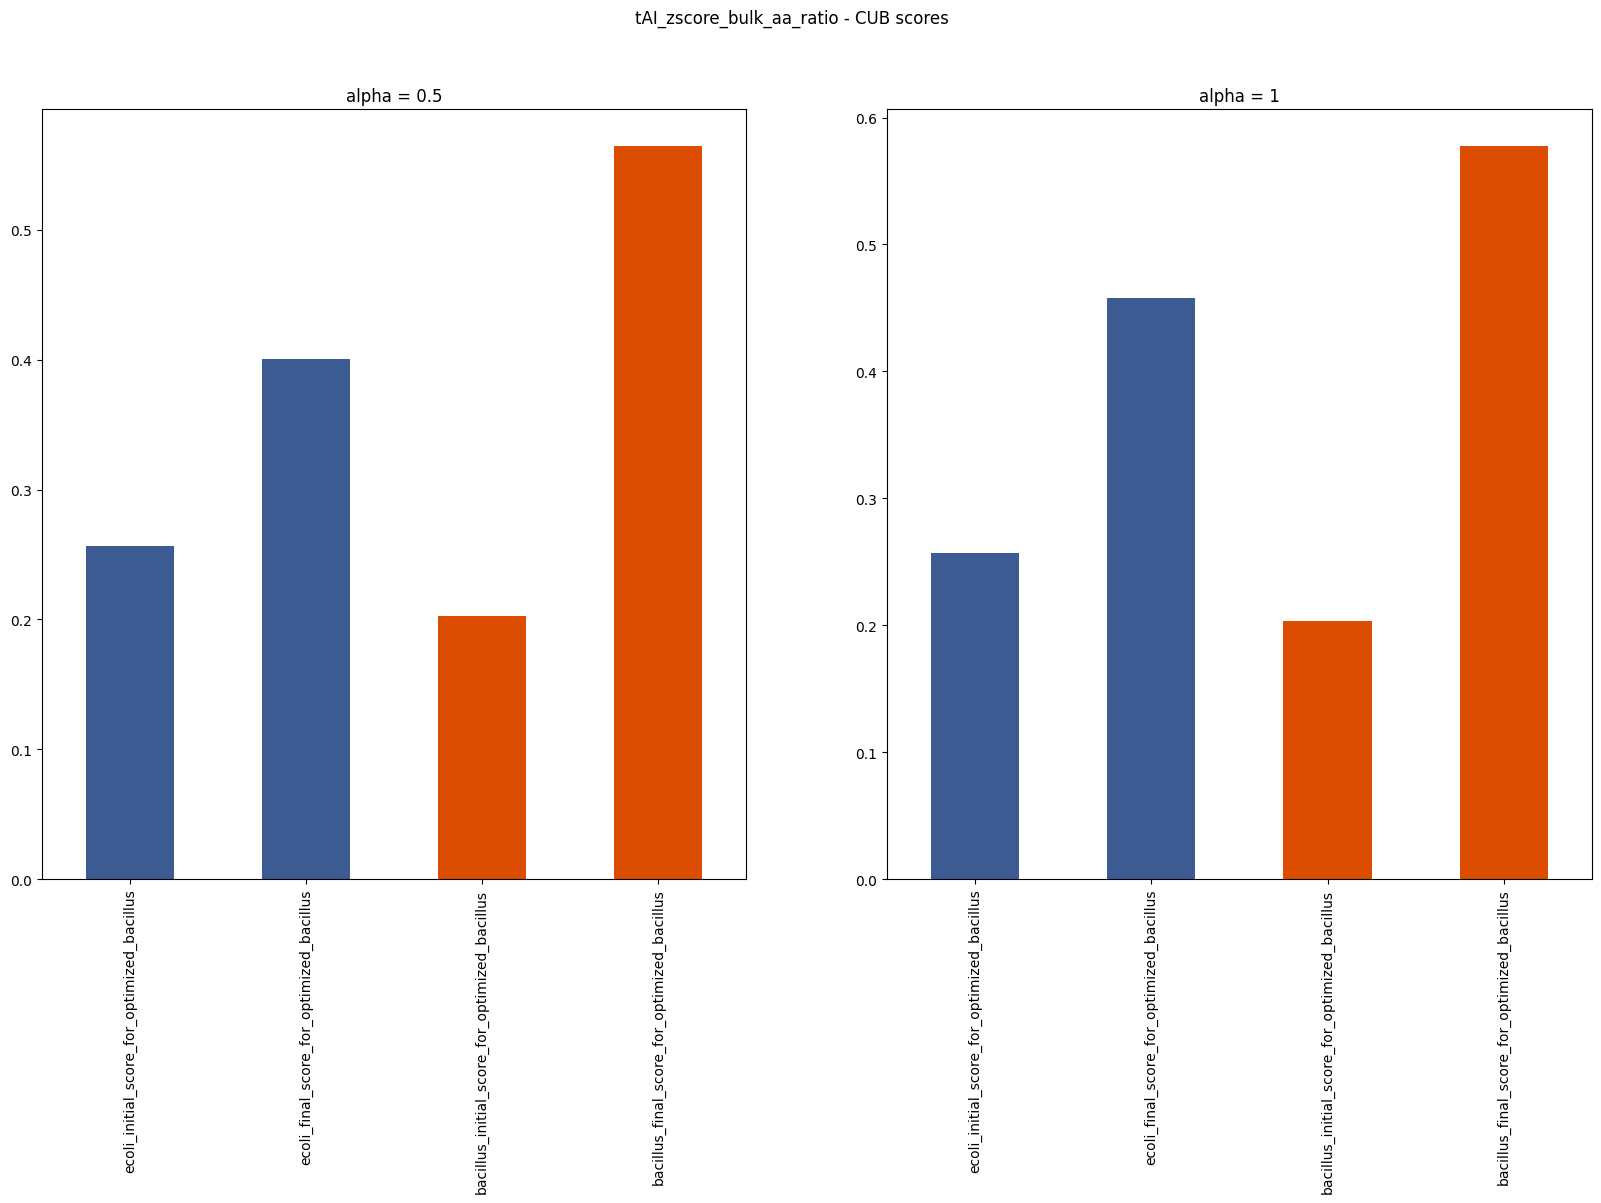

In [33]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
for q in range(cub_bacillus_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    fig.suptitle(cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0.5")
    cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 1")

<AxesSubplot:ylabel='variant'>

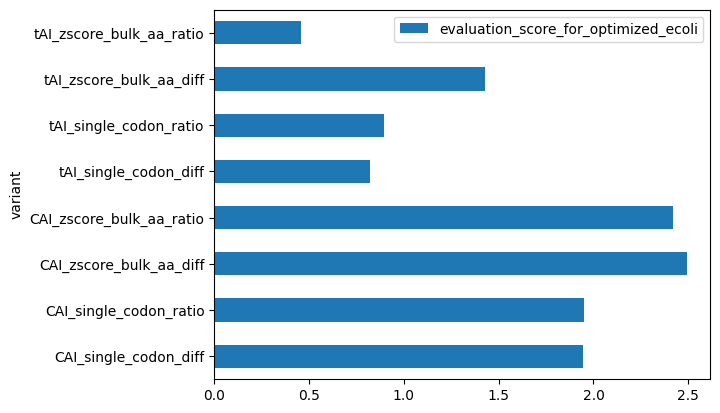

In [37]:
ecoli_opt_variants_dataframe

,variant,ecoli_dist_for_original_mcherry,ecoli_dist_for_optimized_ecoli,bacillus_dist_for_original_mcherry,bacillus_dist_for_optimized_ecoli
0,CAI_single_codon_diff,1.442503,3.665441,1.849371,3.942362
1,CAI_single_codon_ratio,1.442503,3.302358,1.849371,3.783635
2,CAI_zscore_bulk_aa_diff,1.442503,3.663026,1.849371,4.046293
3,CAI_zscore_bulk_aa_ratio,1.442503,3.928597,1.849371,4.119291
4,tAI_single_codon_diff,1.442503,3.632712,1.849371,3.535462
5,tAI_single_codon_ratio,1.442503,3.634687,1.849371,3.701215
6,tAI_zscore_bulk_aa_diff,1.442503,3.326905,1.849371,3.612711
7,tAI_zscore_bulk_aa_ratio,1.442503,3.680889,1.849371,3.471479


,variant,evaluation_score_for_optimized_ecoli,ecoli_dist_for_original_mcherry,ecoli_dist_for_optimized_ecoli,bacillus_dist_for_original_mcherry,bacillus_dist_for_optimized_ecoli,ecoli_dist_diff,bacillus_dist_diff
0,CAI_single_codon_diff,1.944229,1.442503,3.665441,1.849371,3.942362,-0.501727,-2.092991
1,CAI_single_codon_ratio,1.950383,1.442503,3.302358,1.849371,3.783635,-0.507880,-1.934264
2,CAI_zscore_bulk_aa_diff,2.491339,1.442503,3.663026,1.849371,4.046293,-1.048836,-2.196922
3,CAI_zscore_bulk_aa_ratio,2.416923,1.442503,3.928597,1.849371,4.119291,-0.974421,-2.269920
4,tAI_single_codon_diff,0.822074,1.442503,3.632712,1.849371,3.535462,0.620429,-1.686091
5,tAI_single_codon_ratio,0.897232,1.442503,3.634687,1.849371,3.701215,0.545271,-1.851845
6,tAI_zscore_bulk_aa_diff,1.429140,1.442503,3.326905,1.849371,3.612711,0.013363,-1.763340
7,tAI_zscore_bulk_aa_ratio,0.459482,1.442503,3.680889,1.849371,3.471479,0.983021,-1.622108


Text(0.7, 0.9, 'r = -1.000')

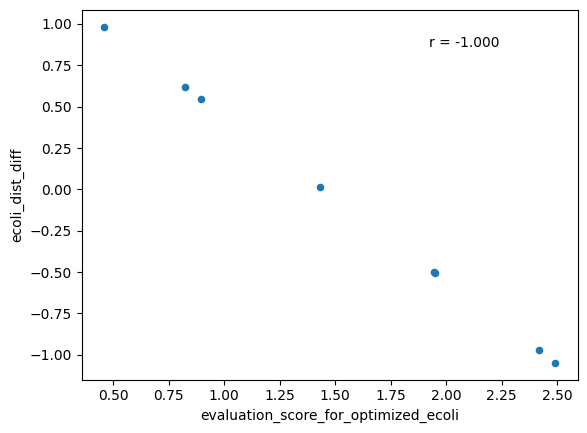